In [2]:
import json
import os
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from operator import itemgetter
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.discrete.discrete_model import Poisson
import statsmodels.api as sm
import pytest
from statsmodels.stats.diagnostic import het_white
import scipy.stats as stats

In [3]:
wd = os.getcwd()
wd = wd.replace('.ipynb_checkpoints', '')
directory = os.path.join(wd, 'data', 'requests5')
retrieved_data =  []
names = []
for file in os.listdir(directory):
    with open(os.path.join(directory, file), "r") as j:
        a = json.loads(j.read())
        retrieved_data.append(a)
        print('Added ', file)
        names.append(file.split('.')[0].split('q')[1])
#retrieved_data
retrieved_data = sorted(retrieved_data, key=itemgetter('citationCount'), reverse=True)

Added  req4Seasons.json
Added  reqA2D2.json
Added  reqA3D.json
Added  reqA9.json
Added  reqaiMotive.json
Added  reqAmodalCityscapes.json
Added  reqAMUSE.json
Added  reqApolloScape.json
Added  reqArgoverse1Stereo.json
Added  reqArgoverse3DTracking.json
Added  reqArgoverseMotionForecasting.json
Added  reqAugKITTI.json
Added  reqAutomatumOpenHighway.json
Added  reqAutonomousPlatformInertial.json
Added  reqBayArea.json
Added  reqBDD100k.json
Added  reqBeyondPASCAL.json
Added  reqBLVD.json
Added  reqBoreas.json
Added  reqBoschSmallTrafficLightsDataset.json
Added  reqBoschTL.json
Added  reqBoxCars116k.json
Added  reqBoxy.json
Added  reqBrain4Cars.json
Added  reqCADC.json
Added  reqCADP.json
Added  reqCaltechLanes.json
Added  reqCaltechPedestrian.json
Added  reqCamVid.json
Added  reqCarlaScenes.json
Added  reqCARLAWildLifeCWL.json
Added  reqCARRADA.json
Added  reqCars.json
Added  reqCCSAD.json
Added  reqCityscapes3D.json
Added  reqCityscapesDVPS.json
Added  reqCODA.json
Added  reqComma2k19.js

In [4]:
print(len(names))
df_name = pd.DataFrame(names)
df_name.to_csv(f'output/retrieved_{len(names)}.csv', index=False, header=False, sep=",")

185


In [5]:
def calc_h_score(citations):
    """Calculates h-index"""
    if citations:
        citations = np.array(citations)
        n         = citations.shape[0]
        array     = np.arange(1, n+1)
        # reverse sorting
        citations = np.sort(citations)[::-1]
        # intersection of citations and k
        h_idx = np.max(np.minimum(citations, array))
        return h_idx
    else:
        return 0

In [6]:
class scoring:
    """For calculating h-indexes and absolut counts of citation-based features"""
    def __init__(self, o_paper, lower_bound, upper_bound, impact_year):
        self.o_paper = o_paper
        self.lower_bound = o_paper['paperInfo']['year'] - lower_bound # years prior to the publication used for calculating various scores
        self.upper_bound = o_paper['paperInfo']['year'] + upper_bound # year after publication used for calculating various scores
        self.impact_year = o_paper['paperInfo']['year'] + impact_year # year(s) after publication when we want to know a papers impact

    def number_citations_authors(self, author):
        """Returns a list where each entry is the number of citations a paper by a given author had up until the given year. Ignores citations without year resulting in different counts compared to the one given by the API."""
        ls_citations = []
        for paper in self.o_paper['paperInfo']['authors'][author]['authorsPapers']:
            #print(paper)
            if 'year' in paper and paper['year'] is not None and paper['year'] <= self.upper_bound:
                numb_cit = 0
                for citation in paper['citations']:
                    if 'year' in citation and citation['year'] is not None and self.upper_bound >= citation[
                        'year'] >= self.lower_bound:
                        numb_cit += 1
                else:
                    ls_citations.append(numb_cit)
        return ls_citations

    def number_citations_ref(self, dimension='references', dimension_papers='citations'):
        """Like number_citations but the list elements represent the citations the references/citations of a paper received."""
        ls_citations = []
        for paper in self.o_paper['paperInfo'][dimension]:
            if paper['year'] is not None and paper['year'] <= self.upper_bound and 'citations' in paper.keys():
                numb_cit = 0
                for citation in paper[dimension_papers]:
                    if citation['year'] is not None and self.upper_bound >= citation['year'] >= self.lower_bound:
                        numb_cit += 1
                else:
                    ls_citations.append(numb_cit)
        return ls_citations

    def just_citations(self):
        """Citation count of a paper prior to impact year and after lower bound"""
        numb_cit = 0
        for paper in self.o_paper['paperInfo']['citations']:
            if paper['year'] is not None and self.impact_year >= paper['year'] >= self.lower_bound:
                        numb_cit += 1
        return numb_cit

    def just_citations_non_cumulative(self):
        """Returns citation count for only a year instead of cumulatively"""
        numb_cit = 0
        for paper in self.o_paper['paperInfo']['citations']:
            #print(paper)
            if paper['year'] is not None and self.impact_year == paper['year']:
                        numb_cit += 1
                        #print((paper['year'] + self.impact_year))
        return numb_cit
    def reference_score(self):
        return calc_h_score(self.number_citations_ref())
    def citations_citations_score(self):
        return calc_h_score(self.number_citations_ref('citations', 'citations'))
    def citations_citations_sum(self):
        return np.sum(self.number_citations_ref('citations', 'citations'))
    def citations_single_author_score(self, author_number):
        return calc_h_score(self.number_citations_authors(author_number))


In [7]:
impact_year = 9
ind_paper = 0
print(retrieved_data[ind_paper]['id'])
scorer = scoring(retrieved_data[ind_paper], 200, 0, impact_year)
print(impact_year, retrieved_data[ind_paper]['paperInfo']['year']+impact_year, scorer.just_citations_non_cumulative())

KITTI
9 2022 987


When do citations take off

In [53]:
def citation_timeline_array(retrieved_data):
    """Columns are years, rows datasets. column 0 is year prior to publication. column 1 year of pub. etc. entries are #citations that year"""
    array = np.zeros([len(retrieved_data), 16])
    names = []
    for paper_idx, paper in enumerate(tqdm(retrieved_data)): #iterate over all papers
        names.append(paper['id'])
        if 'paperInfo' in retrieved_data[paper_idx].keys() and 'year' in retrieved_data[paper_idx]['paperInfo'].keys(): #check if paper has info on year
            array_idx = 0
            for impact_year in range(-1, 2022-retrieved_data[paper_idx]['paperInfo']['year']+1, 1):
                # iterates from 1 year prior to publication until today. e.g. kitti pub in 2012 2011-2022 -> last entry column 9
                scorer = scoring(paper, 200, 0, impact_year)
                array[paper_idx][array_idx] = scorer.just_citations() #calulate citation count of paper
                array_idx += 1
    return array, names
array, name = citation_timeline_array(retrieved_data)
array

100%|██████████| 185/185 [00:00<00:00, 1432.89it/s]


array([[  1.,   7.,  90., ...,   0.,   0.,   0.],
       [  0.,   1.,  10., ...,   0.,   0.,   0.],
       [  5.,  97., 479., ...,   0.,   0.,   0.],
       ...,
       [  0.,   3.,   9., ...,   0.,   0.,   0.],
       [  0.,   0.,   1., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [56]:
#select three first years (approx. 50 papers haven't been out for 3 years so we loose them)
data = array
data = np.delete(data, np.s_[-12:], axis=1)
df = pd.DataFrame(data).set_axis(name)#
for column in range(df.shape[1]):
    if column >= 3:
        df = df[df[column] > 0]
data = np.array(df)

Plot time-line of the citation count of all papers

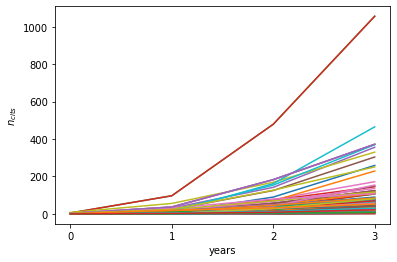

In [10]:
df_transpose = df.transpose()
df_transpose.plot()
plt.legend().remove()
plt.xlabel('years')
plt.ylabel('$n_{cits}$')
plt.xticks([*range(4)], [*range(4)])
plt.savefig('output/citations_over_time.pdf')
plt.show()
#df_transpose

Identify how many clusters are appropriate through an elbow plot

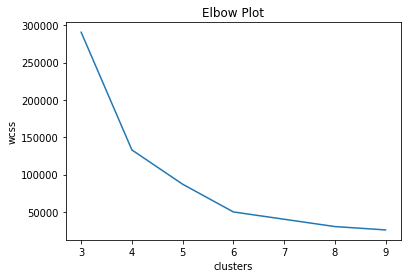

In [11]:
wcss = []
for k in range(3, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
plt.plot([*range(3, 10)], wcss)
plt.title('Elbow Plot')
plt.xlabel('clusters')
plt.ylabel('wcss')
plt.show()

Slect the last bend at 6 clusters. (Compared to 4 clusters, the bottom cluster is split in two, which makes a difference in year 3)

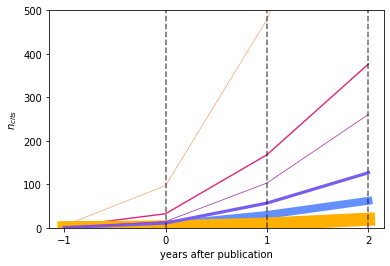

In [55]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(data)
clusters = kmeans.cluster_centers_
colors = ['#648fff', '#fe6100', '#dc267f', '#ffb000', '#785ef0', '#A740AE']
labels = pd.Series(kmeans.labels_)
labels = labels.value_counts(ascending=True).sort_index()
for label, cluster in enumerate(clusters):
    plt.plot([*range(-1, cluster.shape[0]-1)], cluster, alpha=1, label=label, color=colors[label] ,lw=labels.iloc[label]/5)
    #print(labels.iloc[label])
y_lim = 500
plt.ylim(0, y_lim)
plt.vlines(0, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.vlines(1, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.vlines(2, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)

#plt.hlines(100, 0, 4, colors='black', linestyles='dashed', alpha=0.6)
plt.xticks([*range(-1, cluster.shape[0]-1)])
plt.xlabel('years after publication')
plt.ylabel('$n_{cits}$')
plt.savefig('output/citations_clustering.pdf', bbox_inches='tight')
plt.show()

In [13]:
for clu in clusters:
    print(clu)

[ 0.23076923  6.74358974 29.66666667 62.12820513]
[   5.   97.  479. 1056.]
[  2.71428571  32.28571429 168.         376.71428571]
[ 0.07575758  1.8030303   8.46969697 19.71212121]
[  0.4375  10.8125  56.8125 126.625 ]
[  1.    14.5  103.   260.75]


In [14]:
labels = pd.Series(kmeans.labels_)
labels.value_counts(ascending=True)

1     2
5     4
2     7
4    16
0    39
3    66
dtype: int64

In [15]:
def create_modelling_df_altmetric_sensor(retrieved_data, lower_bound, upper_bound, impact_year):
    """creates df for regression from retrieved data with sensor & altmetric. lower bound and upper bound give the respective first and last year for calulcating scores. Impact year the year for which the citation count should be calculated"""
    array = np.zeros([len(retrieved_data), 4])
    for paper_idx, paper in enumerate(tqdm(retrieved_data)):
        if 'paperInfo' in retrieved_data[paper_idx].keys() and 'year' in retrieved_data[paper_idx]['paperInfo'].keys():
            array_idx = 0
            o_paper = retrieved_data[paper_idx]
            scorer = scoring(o_paper, lower_bound, upper_bound, impact_year)
            citation_c = scorer.just_citations()
            citations_citations_c = scorer.citations_citations_score()
            reference_score_c = scorer.reference_score()
            ls_author_scores = []
            for author_number, author in enumerate(o_paper['paperInfo']['authors']):
                single_author_score = scorer.citations_single_author_score(author_number)
                ls_author_scores.append(single_author_score)
            first_author_score = round(ls_author_scores[0], 0)
            if len(ls_author_scores)>1:
                #print(len(ls_author_scores), ls_author_scores)
                mean_author_score = np.mean(ls_author_scores[:])
            elif len(ls_author_scores)==2:
                mean_author_score = ls_author_scores[1]
            else:
                mean_author_score = 0
            array[paper_idx][:4] = [citation_c, citations_citations_c, reference_score_c,  mean_author_score] #, first_author_score
            array_idx += 1
    names = []
    year = []
    sensors = []
    frames = []
    similar_age_3m = []
    row_w_missing_data = []
    missing_altmetirc_counter = 0
    for idx_paper, paper in enumerate(retrieved_data):
        names.append(paper['id'])
        year.append(paper['paperInfo']['year'])
        try:
            similar_age_3m_value = paper['altmetrics'][2]['similar_age_3m_percentile']['percentile']
        except:
            row_w_missing_data.append(idx_paper)
            missing_altmetirc_counter += 1
            continue
        try:
            sensors_value = int(len(list(paper['sensors'].split(','))))
            if paper['frames'] != "-":
                frames_value = (paper['frames'])
            else:
                row_w_missing_data.append(idx_paper)
                continue
        except:
            row_w_missing_data.append(idx_paper)
            continue
        frames.append(frames_value)
        sensors.append(sensors_value)
        similar_age_3m.append(similar_age_3m_value)
    df = pd.DataFrame(array).set_axis(names)
    df['year'] = year
    df = df.drop(df.index[row_w_missing_data])
    print("Missing Data (due to missing features):", len(row_w_missing_data))
    df['sensors'] = sensors
    df['frames'] = frames
    df['similar_age_3m_percentile'] = similar_age_3m
    cols = list(df.columns)
    cols[:4] = ['citation_c', 'citations_citations_c', 'reference_score_c', 'mean_author_score'] #, 'first_author_score'
    df.columns = cols

    before = df.shape[0]
    df = df[df.year <= (2022-impact_year)]
    print('Missing Data (due to missing features):', (before-df.shape[0]))
    print('Warning. This function still has altmetrics')
    return df

In [16]:
def create_modelling_df_senors(retrieved_data, lower_bound, upper_bound, impact_year):
    """creates df for regression from retrieved data with sensor. lower bound and upper bound give the respective first and last year for calculating scores. Impact year the year for which the citation count should be calculated"""
    array = np.zeros([len(retrieved_data), 4])
    for paper_idx, paper in enumerate(tqdm(retrieved_data)):
        if 'paperInfo' in retrieved_data[paper_idx].keys() and 'year' in retrieved_data[paper_idx]['paperInfo'].keys():
            array_idx = 0
            o_paper = retrieved_data[paper_idx]
            scorer = scoring(o_paper, lower_bound, upper_bound, impact_year)
            citation_c = scorer.just_citations()
            citations_citations_c = scorer.citations_citations_score()
            reference_score_c = scorer.reference_score()
            ls_author_scores = []
            for author_number, author in enumerate(o_paper['paperInfo']['authors']):
                single_author_score = scorer.citations_single_author_score(author_number)
                ls_author_scores.append(single_author_score)
            first_author_score = round(ls_author_scores[0], 0)
            if len(ls_author_scores)>1:
                #print(len(ls_author_scores), ls_author_scores)
                mean_author_score = np.mean(ls_author_scores[:])
            elif len(ls_author_scores)==2:
                mean_author_score = ls_author_scores[1]
            else:
                mean_author_score = 0
            array[paper_idx][:4] = [citation_c, citations_citations_c, reference_score_c,  mean_author_score] #, first_author_score
            array_idx += 1
    names = []
    year = []
    sensors = []
    frames = []
    row_w_missing_data = []
    for idx_paper, paper in enumerate(retrieved_data):
        names.append(paper['id'])
        year.append(paper['paperInfo']['year'])
        try:
            if paper['frames'] != "-":
                frames_value = (paper['frames'])
            else:
                row_w_missing_data.append(idx_paper)
                continue
        except:
            row_w_missing_data.append(idx_paper)
            continue
        try:
            sensors_value = int(len(list(paper['sensors'].split(','))))
        except:
            print('hello')
            row_w_missing_data.append(idx_paper)
            continue

        frames.append(frames_value)
        sensors.append(sensors_value)
    df = pd.DataFrame(array).set_axis(names)
    df['year'] = year
    df = df.drop(df.index[row_w_missing_data])
    print("Missing Data (due to missing features):", len(row_w_missing_data))
    df['sensors'] = sensors
    df['frames'] = frames
    cols = list(df.columns)
    cols[:4] = ['citation_c', 'citations_citations_c', 'reference_score_c', 'mean_author_score'] #, 'first_author_score'
    df.columns = cols

    before = df.shape[0]
    df = df[df.year <= (2022-impact_year)]
    print('Missing Data (due to missing years):', (before-df.shape[0]))
    print('Warning. This function still has sensors')
    return df

In [17]:
def create_modelling_df_no_sensor(retrieved_data, lower_bound, upper_bound, impact_year):
    """creates df for regression from retrieved data with. lower bound and upper bound give the respective first and last year for calculating scores. Impact year the year for which the citation count should be calculated"""
    array = np.zeros([len(retrieved_data), 4])
    for paper_idx, paper in enumerate(tqdm(retrieved_data)):
        if 'paperInfo' in retrieved_data[paper_idx].keys() and 'year' in retrieved_data[paper_idx]['paperInfo'].keys():
            array_idx = 0
            o_paper = retrieved_data[paper_idx]
            scorer = scoring(o_paper, lower_bound, upper_bound, impact_year)
            citation_c = scorer.just_citations()
            citations_citations_c = scorer.citations_citations_score()
            reference_score_c = scorer.reference_score()
            ls_author_scores = []
            for author_number, author in enumerate(o_paper['paperInfo']['authors']):
                single_author_score = scorer.citations_single_author_score(author_number)
                ls_author_scores.append(single_author_score)
            first_author_score = round(ls_author_scores[0], 0)
            if len(ls_author_scores)>1:
                #print(len(ls_author_scores), ls_author_scores)
                mean_author_score = np.mean(ls_author_scores[:])
            elif len(ls_author_scores)==2:
                mean_author_score = ls_author_scores[1]
            else:
                mean_author_score = 0
            array[paper_idx][:4] = [citation_c, citations_citations_c, reference_score_c,  mean_author_score] #, first_author_score
            array_idx += 1
    names = []
    year = []
    frames = []
    row_w_missing_data = []
    for idx_paper, paper in enumerate(retrieved_data):
        names.append(paper['id'])
        year.append(paper['paperInfo']['year'])
        try:
            if paper['frames'] != "-":
                frames_value = (paper['frames'])
            else:
                row_w_missing_data.append(idx_paper)
                continue
        except:
            row_w_missing_data.append(idx_paper)
            continue
        frames.append(frames_value)
    df = pd.DataFrame(array).set_axis(names)
    df['year'] = year
    df = df.drop(df.index[row_w_missing_data])
    print('Missing Data (due to missing features):', len(row_w_missing_data))
    df['frames'] = frames
    cols = list(df.columns)
    cols[:4] = ['citation_c', 'citations_citations_c', 'reference_score_c', 'mean_author_score'] #, 'first_author_score'
    df.columns = cols
    #print(row_w_missing_data)
    before = df.shape[0]
    df = df[df.year <= (2022-impact_year)]
    print('Missing Data (due to missing years):', (before-df.shape[0]))
    return df

In [18]:
def convert_and_plot_data(df, drop='citations_citations_c', dependent_var='citation_c'):
    """clean up wrong value and convert to log scale"""
    #replacement = df.at['Street Learn', 'frames'].replace(',', '')
    #print(replacement)
    #df.at['Street Learn', 'frames'] = replacement
    modelling_df = df
    # modelling_df = modelling_df.drop(['BDD100k', 'Argoverse Motion Forecasting'], axis=0)
    modelling_df = modelling_df.drop([drop], axis=1)
    for idx_column, col in enumerate(modelling_df.columns):
        modelling_df[col] = modelling_df[col].astype("float")
    for idx, variable in enumerate(modelling_df):
        plt.scatter(modelling_df[variable], modelling_df[dependent_var])
        plt.xlabel(list(modelling_df.columns)[idx])
        plt.show()
        plt.hist(modelling_df[variable])
        plt.show()
    print(modelling_df.frames.max())
    modelling_df[dependent_var] = np.log(modelling_df[dependent_var]+1)
    modelling_df.frames = np.log(modelling_df.frames+1)
    return modelling_df

def normalize(modelling_df, dependent_var='citation_c'):
    """normalize df before modelling"""
    for idx_column, col in enumerate(modelling_df.columns):
        if col != dependent_var:
                modelling_df[col] = (modelling_df[col]-modelling_df[col].mean())/(modelling_df[col].std())
                plt.scatter(modelling_df[col], modelling_df[dependent_var])
                plt.xlabel(list(modelling_df.columns)[idx_column])
                plt.show()
    return modelling_df

def modelling(modelling_df, dependent_var='citation_c'):
    """do regression with statistics"""
    independent_vars = modelling_df.drop([dependent_var], axis=1)
    X = add_constant(independent_vars)
    y = modelling_df[dependent_var]
    mod = sm.regression.linear_model.OLS(y, independent_vars.assign(intercept=1))
    res = mod.fit(cov_type="HC1")
    print(res.summary())
    test = sm.stats.diagnostic.het_breuschpagan(res.resid, res.model.exog)
    print('test', test)
    vif = pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)
    print(vif)
    #perform White's test
    white_test = het_white(res.resid,  res.model.exog)

    #define labels to use for output of White's test
    labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

    #print results of White's test
    print(dict(zip(labels, white_test)))
    fig = sm.qqplot(res.resid, stats.t, fit=True, line='45')
    plt.title('QQ_plot')
    plt.show()
    fitted_y = res.fittedvalues
    plot = sns.residplot(x=fitted_y, y=modelling_df[dependent_var], data=modelling_df, lowess=True)
    plt.show()
    for variable in independent_vars:
        plot = sns.residplot(x=independent_vars[variable], y=modelling_df[dependent_var], data=modelling_df, lowess=True)
        plt.show()
    return res, fitted_y, y, independent_vars


wd = os.getcwd()
wd = wd.replace('.ipynb_checkpoints', '')
directory = os.path.join(wd, 'data', 'requests5')
retrieved_data =  []
for file in os.listdir(directory):
    with open(os.path.join(directory, file), "r") as j:
        a = json.loads(j.read())
        retrieved_data.append(a)

retrieved_data = sorted(retrieved_data, key=itemgetter('citationCount'), reverse=True)

Including altmetrics leads to 159 missing observations. Including sensors if frames is included leads to no missing values.

100%|██████████| 185/185 [00:06<00:00, 27.82it/s]


Missing Data (due to missing features): 76
Missing Data (due to missing years): 39
Warning. This function still has sensors


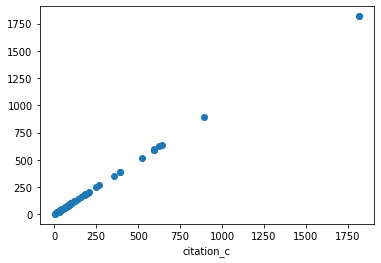

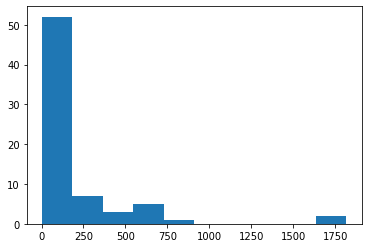

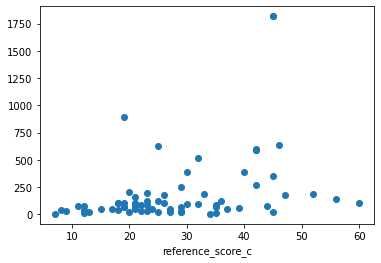

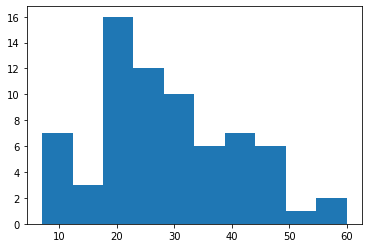

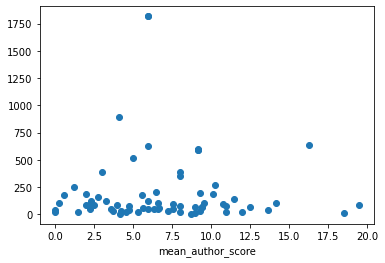

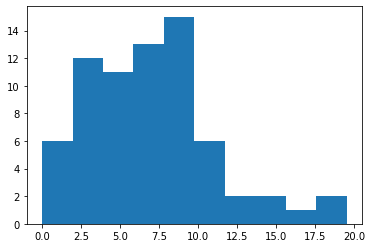

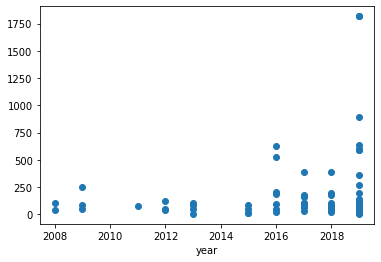

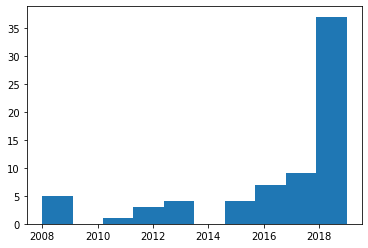

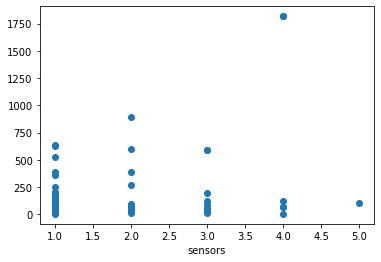

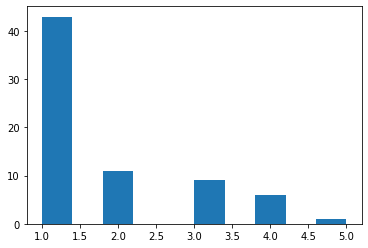

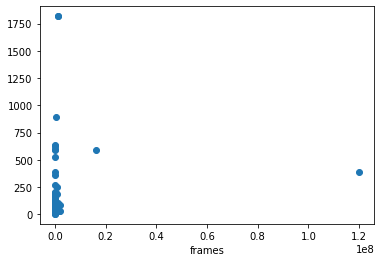

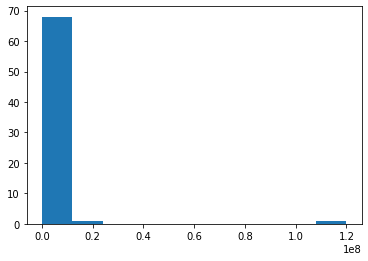

120000000.0


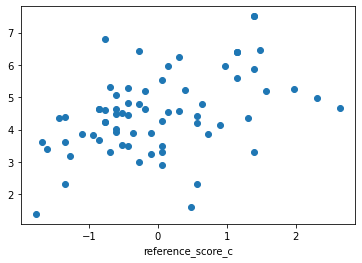

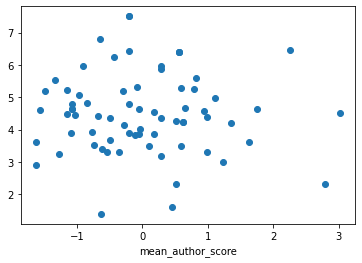

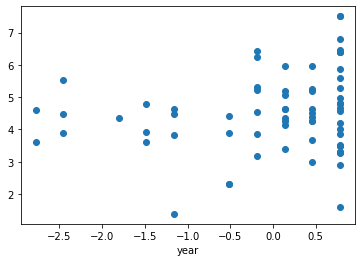

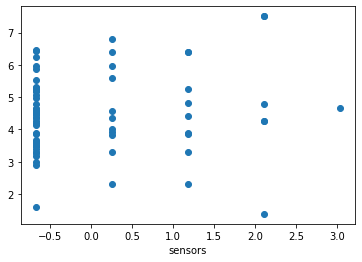

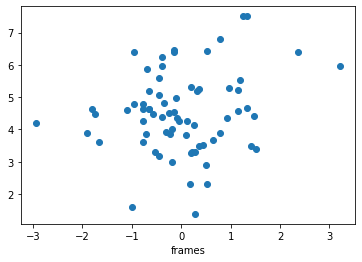

                            OLS Regression Results                            
Dep. Variable:             citation_c   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     4.264
Date:                Tue, 03 Jan 2023   Prob (F-statistic):            0.00208
Time:                        20:22:18   Log-Likelihood:                -105.04
No. Observations:                  70   AIC:                             222.1
Df Residuals:                      64   BIC:                             235.6
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
reference_score_c     0.5974      0.15

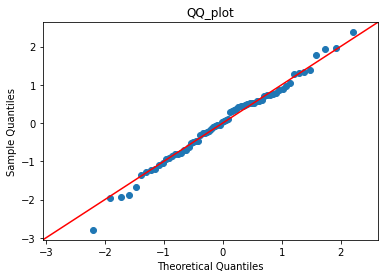

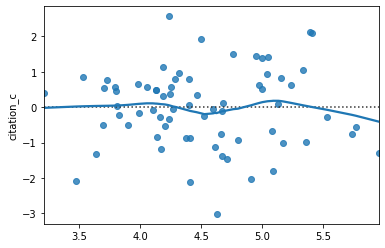

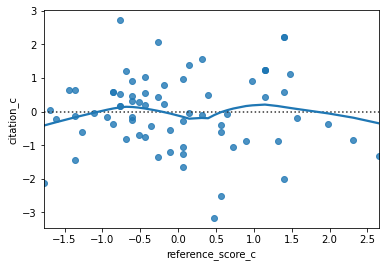

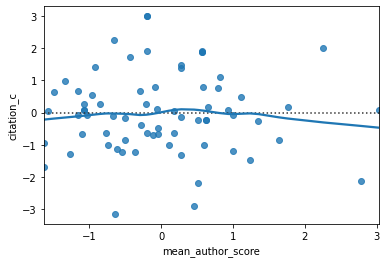

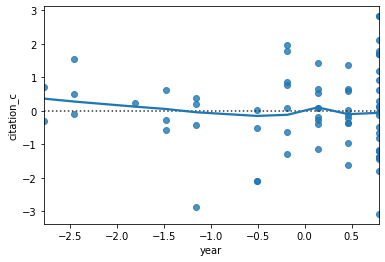

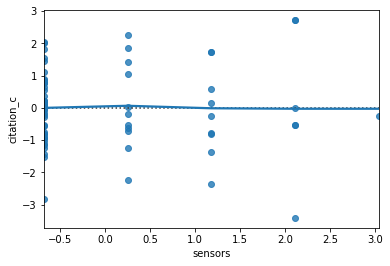

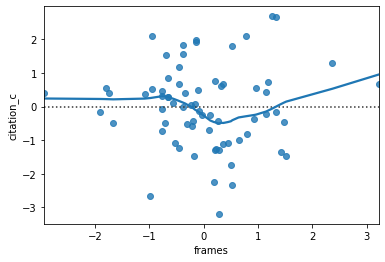

107341.38142269482


In [19]:
df = create_modelling_df_senors(retrieved_data, 3, 0, 3)
modelling_df = convert_and_plot_data(df)
modelling_df_normalized = normalize(modelling_df)
res3, fitted_y, y_ols, x = modelling(modelling_df_normalized)
print(sm.tools.eval_measures.mse(np.exp(fitted_y)-1, np.exp(y_ols))-1)

In [20]:
#save result
with open("output/regression_3_years.csv", 'w') as csvFile:
    single = res3.summary().as_csv()
    lns = single.split(";")
    for item in lns:
        csvFile.write(item.replace("=", ",") + os.linesep)

Making Citation Predictor with XGB - no good results

In [21]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    modelling_df.drop(['citation_c'], axis=1), modelling_df['citation_c'], test_size=0.3, random_state=13
)
X_train, X_fin, y_train, y_fin = train_test_split(
    X_test, y_test, test_size=0.3, random_state=13
)

In [23]:
params = {
    "n_estimators": 10,
    "max_depth": 20,
    "min_samples_split": 3,
    "learning_rate": 0.8,
    "loss": "squared_error",
}

In [24]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.8, max_depth=20, min_samples_split=3,
                          n_estimators=10)

In [25]:
mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
r2 = r2_score(y_test, reg.predict(X_test))
print("The R squared  (R2) on test set: {:.4f}".format(r2))

The mean squared error (MSE) on test set: 0.6785
The R squared  (R2) on test set: 0.5479


The mean absolute error (MAE) on test set: 51.6033
The mean squared error (MSE) on test set: 13432.6607


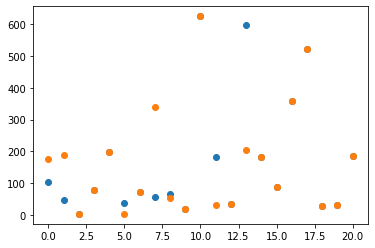

In [26]:

comparison = [np.exp(y_test), np.exp(reg.predict(X_test))]
mae = mean_absolute_error(comparison[0], comparison[1])
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
mse = mean_squared_error(comparison[0], comparison[1])
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
plt.scatter([*range(len(y_test))], comparison[0])
plt.scatter([*range(len(y_test))], comparison[1])
plt.show()

The mean absolute error (MAE) on test set: 154.8096
The mean squared error (MSE) on test set: 40297.9822


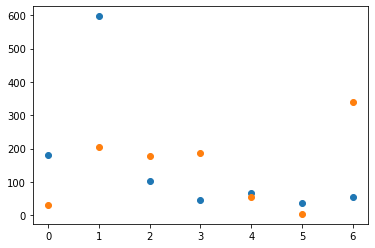

In [27]:
comparison = [np.exp(y_fin), np.exp(reg.predict(X_fin))]
mae = mean_absolute_error(comparison[0], comparison[1])
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
mse = mean_squared_error(comparison[0], comparison[1])
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
plt.scatter([*range(len(comparison[0]))], comparison[0])
plt.scatter([*range(len(comparison[0]))], comparison[1])
plt.show()

### Table of Features and Influence Score of all papers from 2022

In [28]:
wd = os.getcwd()
wd = wd.replace('.ipynb_checkpoints', '')
directory = os.path.join(wd, 'data', 'requests5')
retrieved_data =  []
print('Importing data again')
for file in os.listdir(directory):
    with open(os.path.join(directory, file), "r") as j:
        a = json.loads(j.read())
        retrieved_data.append(a)
retrieved_data = sorted(retrieved_data, key=itemgetter('citationCount'), reverse=True)

Importing data again


Make array with all features of all data to calculate percentile ranks

In [29]:
yr = 2022
array = np.empty([len(retrieved_data), 9])
array[:] = np.nan
names = []
'''
self.lower_bound = 2019 = o_paper['paperInfo']['year'] - (o_paper['paperInfo']['year'] - 2022 + 3)# years prior to the publication used for calculating various scores
self.upper_bound = 2022 = o_paper['paperInfo']['year'] + (-o_paper['paperInfo']['year']+2022) # year after publication used for calculating various scores
self.impact_year = 2022 = o_paper['paperInfo']['year'] + impact_year # year(s) after publication when we want to know a papers impact
'''
for paper_idx, o_paper in enumerate(tqdm(retrieved_data)):
    dist = 2022 - o_paper['paperInfo']['year'] #2022 - o_paper['paperInfo']['year']

    scorer = scoring(o_paper, -dist+2, dist, dist)
    reference = scorer.reference_score()
    citations_citations = scorer.citations_citations_score()
    citations = scorer.just_citations()

    print(paper_idx, o_paper['id'], 'citations', citations, 'year:', o_paper['paperInfo']['year'])
    print('scorer', scorer.lower_bound, scorer.upper_bound, scorer.impact_year)

    ls_author_scores = []
    names.append(o_paper['id'])
    for author_number, author in enumerate(o_paper['paperInfo']['authors']):
        single_author_score = scorer.citations_single_author_score(author_number)
        ls_author_scores.append(single_author_score)
    author = np.mean(ls_author_scores)
    try:
        score = o_paper['altmetrics'][0]['score']
    except:
        score = float("NaN")
    try:
        total_readers = o_paper['altmetrics'][3]['total_readers']
    except:
        total_readers = float("NaN")
    try:
        sensors_value = int(len(list(o_paper['sensors'].split(','))))
    except:
        sensors_value = float("NaN")
    try:
        if o_paper['frames'] != "-":
                frames_value = int(o_paper['frames'].replace(',', ''))
        else:
            frames_value = float("NaN")
    except:
                frames_value = float("NaN")
    publication = o_paper['paperInfo']['year']


    array[paper_idx][:] = [citations, citations_citations, total_readers, score, reference, author, sensors_value, frames_value, publication]

  2%|▏         | 4/185 [00:00<00:34,  5.30it/s]

0 KITTI citations 3004 year: 2013
scorer 2020 2022 2022
1 Cars citations 1305 year: 2013
scorer 2020 2022 2022
2 nuImages citations 1720 year: 2019
scorer 2020 2022 2022
3 nuScenes citations 1720 year: 2019
scorer 2020 2022 2022
4 Synthia citations 918 year: 2016
scorer 2020 2022 2022
5 GTA5 citations 780 year: 2016
scorer 2020 2022 2022


  4%|▍         | 7/185 [00:01<00:36,  4.86it/s]

6 Caltech Pedestrian citations 333 year: 2009
scorer 2020 2022 2022


  8%|▊         | 14/185 [00:01<00:16, 10.66it/s]

7 CamVid citations 468 year: 2009
scorer 2020 2022 2022
8 Oxford Robot Car citations 619 year: 2017
scorer 2020 2022 2022
9 Waymo Open Perception citations 886 year: 2019
scorer 2020 2022 2022
10 GTSRB citations 316 year: 2011
scorer 2020 2022 2022
11 Mapillary Vistas citations 528 year: 2017
scorer 2020 2022 2022
12 Caltech Lanes citations 201 year: 2008
scorer 2020 2022 2022
13 BDD100k citations 613 year: 2018
scorer 2020 2022 2022
14 Beyond PASCAL citations 249 year: 2014
scorer 2020 2022 2022
15 Argoverse 3D Tracking citations 557 year: 2019
scorer 2020 2022 2022


 12%|█▏        | 22/185 [00:02<00:08, 19.44it/s]

16 Argoverse Motion Forecasting citations 557 year: 2019
scorer 2020 2022 2022
17 GTSDB citations 263 year: 2013
scorer 2020 2022 2022
18 LISA Traffic Sign citations 166 year: 2012
scorer 2020 2022 2022
19 TT100K citations 236 year: 2016
scorer 2020 2022 2022
20 CULane citations 355 year: 2017
scorer 2020 2022 2022
21 TUD Brussels citations 57 year: 2009
scorer 2020 2022 2022
22 ApolloScape citations 244 year: 2018
scorer 2020 2022 2022
23 Road Damage citations 192 year: 2018
scorer 2020 2022 2022


 17%|█▋        | 31/185 [00:02<00:05, 28.64it/s]

24 VPGNet citations 204 year: 2017
scorer 2020 2022 2022
25 DDAD citations 260 year: 2019
scorer 2020 2022 2022
26 NoCrash citations 202 year: 2019
scorer 2020 2022 2022
27 Malaga Stereo and Laser Urban citations 89 year: 2014
scorer 2020 2022 2022
28 INTERACTION citations 192 year: 2019
scorer 2020 2022 2022
29 Brain4Cars citations 77 year: 2015
scorer 2020 2022 2022
30 comma.ai citations 79 year: 2016
scorer 2020 2022 2022
31 Oxford Radar Robot Car citations 168 year: 2019
scorer 2020 2022 2022
32 Stanford Track Collection citations 34 year: 2011
scorer 2020 2022 2022
33 India Driving citations 151 year: 2018
scorer 2020 2022 2022
34 LISA Traffic Light citations 67 year: 2016
scorer 2020 2022 2022
35 Bosch Small Traffic Lights Dataset citations 88 year: 2017
scorer 2020 2022 2022


 24%|██▍       | 45/185 [00:02<00:03, 43.47it/s]

36 Bosch TL citations 88 year: 2017
scorer 2020 2022 2022
37 DR(eye)VE citations 105 year: 2017
scorer 2020 2022 2022
38 KITTI-360 citations 77 year: 2015
scorer 2020 2022 2022
39 JAAD citations 105 year: 2017
scorer 2020 2022 2022
40 Nighttime Driving citations 109 year: 2018
scorer 2020 2022 2022
41 TME Motorway citations 22 year: 2012
scorer 2020 2022 2022
42 KAIST Multi-Spectral Day/Night citations 113 year: 2018
scorer 2020 2022 2022
43 Lyft Level5 Perception citations 124 year: 2020
scorer 2020 2022 2022
44 Lyft Level5 Prediction citations 124 year: 2020
scorer 2020 2022 2022
45 One Thousand and One Hours citations 124 year: 2020
scorer 2020 2022 2022
46 H3D citations 106 year: 2019
scorer 2020 2022 2022
47 WoodScape citations 107 year: 2019
scorer 2020 2022 2022
48 A2D2 citations 116 year: 2020
scorer 2020 2022 2022
49 Complex Urban citations 101 year: 2019
scorer 2020 2022 2022
50 Synscapes citations 91 year: 2018
scorer 2020 2022 2022
51 Waymo Open Motion citations 109 year: 2

 34%|███▎      | 62/185 [00:02<00:02, 56.21it/s]

52 WildDash citations 85 year: 2018
scorer 2020 2022 2022
53 UAH-DriveSet citations 60 year: 2016
scorer 2020 2022 2022
54 BoxCars116k citations 66 year: 2017
scorer 2020 2022 2022
55 Ground Truth Stixel citations 11 year: 2013
scorer 2020 2022 2022
56 DBNet citations 52 year: 2018
scorer 2020 2022 2022
57 LiDAR-Video Driving citations 52 year: 2018
scorer 2020 2022 2022
58 LostAndFound citations 61 year: 2016
scorer 2020 2022 2022
59 Waymo Block-NeRF citations 83 year: 2022
scorer 2020 2022 2022
60 HD1K citations 59 year: 2016
scorer 2020 2022 2022
61 Tsinghua Daimler Cyclist Detection citations 33 year: 2016
scorer 2020 2022 2022
62 CADC citations 74 year: 2020
scorer 2020 2022 2022
63 Street Hazards citations 70 year: 2022
scorer 2020 2022 2022
64 HCI Challenging Stereo citations 9 year: 2012
scorer 2020 2022 2022
65 Toronto 3D citations 66 year: 2020
scorer 2020 2022 2022
66 Fishyscapes citations 59 year: 2019
scorer 2020 2022 2022
67 A*3D citations 51 year: 2019
scorer 2020 2022 2

 40%|████      | 74/185 [00:03<00:03, 33.05it/s]

69 EuroCity Persons citations 112 year: 2019
scorer 2020 2022 2022
70 SemanticPOSS citations 49 year: 2020
scorer 2020 2022 2022
71 ONCE citations 48 year: 2021
scorer 2020 2022 2022
72 RELLIS-3D citations 48 year: 2020
scorer 2020 2022 2022
73 rounD citations 44 year: 2020
scorer 2020 2022 2022
74 PointCloudDeNoising citations 33 year: 2019
scorer 2020 2022 2022
75 Ford Autonomous Vehicle citations 41 year: 2020
scorer 2020 2022 2022


 47%|████▋     | 87/185 [00:04<00:03, 29.65it/s]

76 CADP citations 32 year: 2018
scorer 2020 2022 2022
77 LIBRE citations 39 year: 2020
scorer 2020 2022 2022
78 D^2 City citations 34 year: 2019
scorer 2020 2022 2022
79 CARRADA citations 36 year: 2020
scorer 2020 2022 2022
80 Comma2k19 citations 30 year: 2018
scorer 2020 2022 2022
81 RADIATE citations 27 year: 2020
scorer 2020 2022 2022
82 Street Learn citations 24 year: 2019
scorer 2020 2022 2022
83 DIPLECS Autonomous Driving citations 18 year: 2015
scorer 2020 2022 2022
84 Talk2Car citations 29 year: 2019
scorer 2020 2022 2022
85 Raincouver citations 21 year: 2017
scorer 2020 2022 2022
86 RoadAnomaly21 citations 29 year: 2021
scorer 2020 2022 2022
87 RoadObstacle21 citations 29 year: 2021
scorer 2020 2022 2022
88 4Seasons citations 27 year: 2020
scorer 2020 2022 2022
89 BLVD citations 21 year: 2019
scorer 2020 2022 2022


 57%|█████▋    | 105/185 [00:04<00:01, 50.37it/s]

90 DDD20: DAVIS Driving 2020 citations 26 year: 2020
scorer 2020 2022 2022
91 MTSD citations 26 year: 2019
scorer 2020 2022 2022
92 Unsupervised Llamas citations 25 year: 2019
scorer 2020 2022 2022
93 Bay Area citations 7 year: 2014
scorer 2020 2022 2022
94 Illumination Changes in a day citations 7 year: 2014
scorer 2020 2022 2022
95 RANUS citations 17 year: 2018
scorer 2020 2022 2022
96 Seasonal Variation citations 7 year: 2014
scorer 2020 2022 2022
97 Cityscapes 3D citations 23 year: 2020
scorer 2020 2022 2022
98 DriveU Traffic Light citations 13 year: 2018
scorer 2020 2022 2022
99 PREVENTION citations 23 year: 2019
scorer 2020 2022 2022
100 RadarScenes citations 23 year: 2021
scorer 2020 2022 2022
101 CCSAD citations 9 year: 2015
scorer 2020 2022 2022
102 KITTI-360 PanopticBEV citations 20 year: 2021
scorer 2020 2022 2022
103 nuPlan citations 21 year: 2021
scorer 2020 2022 2022
104 nuScenes PanopticBEV citations 20 year: 2021
scorer 2020 2022 2022
105 AMUSE citations 6 year: 2013
sc

 65%|██████▍   | 120/185 [00:04<00:01, 53.92it/s]

108 openDD citations 14 year: 2020
scorer 2020 2022 2022
109 MCity Data Collection citations 11 year: 2019
scorer 2020 2022 2022
110 Semantic KITTI citations 620 year: 2019
scorer 2020 2022 2022
111 SemanticUSL citations 12 year: 2021
scorer 2020 2022 2022
112 TRoM citations 6 year: 2017
scorer 2020 2022 2022
113 Cooperative Driving (CODD) citations 7 year: 2021
scorer 2020 2022 2022
114 PepScenes citations 6 year: 2020
scorer 2020 2022 2022
115 ScribbleKITTI citations 6 year: 2022
scorer 2020 2022 2022
116 SHIFT citations 6 year: 2022
scorer 2020 2022 2022
117 K-Lane citations 4 year: 2021
scorer 2020 2022 2022
118 WZ-traffic citations 4 year: 2019
scorer 2020 2022 2022
119 CrashD citations 3 year: 2021
scorer 2020 2022 2022
120 WildDash 2 citations 4 year: 2022
scorer 2020 2022 2022
121 Provident Vehicle Detection at Night (PVDN) citations 2 year: 2021
scorer 2020 2022 2022
122 Amodal Cityscapes citations 1 year: 2022
scorer 2020 2022 2022
123 DRIV100 citations 1 year: 2021
scorer 20

 73%|███████▎  | 135/185 [00:04<00:00, 52.28it/s]

126 A9 citations 8 year: 2022
scorer 2020 2022 2022
127 aiMotive citations 0 year: 2022
scorer 2020 2022 2022
128 Argoverse 1 Stereo citations 559 year: 2019
scorer 2020 2022 2022
129 AugKITTI citations 0 year: 2022
scorer 2020 2022 2022
130 Automatum (Open Highway) citations 3 year: 2021
scorer 2020 2022 2022
131 Autonomous Platform Inertial citations 6 year: 2022
scorer 2020 2022 2022
132 Boreas citations 9 year: 2022
scorer 2020 2022 2022
133 CarlaScenes citations 0 year: 2022
scorer 2020 2022 2022
134 CARLA-WildLife (CWL) citations 0 year: 2022
scorer 2020 2022 2022


 76%|███████▌  | 141/185 [00:04<00:01, 41.85it/s]

135 Cityscapes-DVPS citations 58 year: 2020
scorer 2020 2022 2022
136 CODA citations 6 year: 2022
scorer 2020 2022 2022
137 CURE-TSD citations 31 year: 2019
scorer 2020 2022 2022
138 CURE-TSR citations 28 year: 2017
scorer 2020 2022 2022
139 DGL-MOTS citations 333 year: 2019
scorer 2020 2022 2022
140 ETH Pedestrian citations 142 year: 2008
scorer 2020 2022 2022
141 exiD citations 2 year: 2022
scorer 2020 2022 2022
142 Five Roundabouts citations 87 year: 2018
scorer 2020 2022 2022
143 Ford CAMPUS citations 110 year: 2011
scorer 2020 2022 2022
144 Gated2Depth citations 22 year: 2019
scorer 2020 2022 2022
145 Gated2Gated citations 1 year: 2021
scorer 2020 2022 2022


 82%|████████▏ | 151/185 [00:05<00:00, 41.24it/s]

146 GROUNDED citations 2 year: 2021
scorer 2020 2022 2022
147 HAD citations 25 year: 2019
scorer 2020 2022 2022
148 HDBD citations 0 year: 2022
scorer 2020 2022 2022
149 HDD citations 109 year: 2018
scorer 2020 2022 2022
150 HEV-I citations 61 year: 2018
scorer 2020 2022 2022
151 highD citations 361 year: 2018
scorer 2020 2022 2022
152 HSD citations 11 year: 2019
scorer 2020 2022 2022
153 IDDA citations 20 year: 2020
scorer 2020 2022 2022
154 inD citations 131 year: 2019
scorer 2020 2022 2022
155 IPS300+ citations 3 year: 2021
scorer 2020 2022 2022


 85%|████████▌ | 158/185 [00:05<00:00, 47.60it/s]

156 I see you citations 0 year: 2022
scorer 2020 2022 2022
157 K-Radar citations 1 year: 2022
scorer 2020 2022 2022
158 LISA Amazon-MLSL Vehicle Attributes (LAVA) citations 0 year: 2021
scorer 2020 2022 2022
159 LOKI citations 12 year: 2021
scorer 2020 2022 2022
160 MAVD Multimodal Audio-Visual Detection citations 32 year: 2021
scorer 2020 2022 2022
161 MOTSynth citations 30 year: 2021
scorer 2020 2022 2022
162 MuIRan citations 90 year: 2020
scorer 2020 2022 2022
163 Multi Vehicle Stereo Event Camera citations 164 year: 2018
scorer 2020 2022 2022


 92%|█████████▏| 170/185 [00:05<00:00, 43.41it/s]

164 NCLT citations 158 year: 2016
scorer 2020 2022 2022
165 OpenMPD citations 5 year: 2022
scorer 2020 2022 2022
166 PIE citations 96 year: 2019
scorer 2020 2022 2022
167 R3 Driving citations 0 year: 2021
scorer 2020 2022 2022
168 RoadSaW citations 0 year: 2022
scorer 2020 2022 2022
169 Rope3D citations 3 year: 2022
scorer 2020 2022 2022
170 RUGD: Robot Unstructured Ground Driving citations 47 year: 2019
scorer 2020 2022 2022


 95%|█████████▍| 175/185 [00:05<00:00, 29.70it/s]

171 R-U-MAAD citations 0 year: 2022
scorer 2020 2022 2022
172 SeeingThroughFog citations 103 year: 2019
scorer 2020 2022 2022
173 SemKITTI-DVPS citations 58 year: 2020
scorer 2020 2022 2022
174 Small Obstacle citations 8 year: 2020
scorer 2020 2022 2022
175 SODA10M citations 7 year: 2021
scorer 2020 2022 2022
176 Stanford Drone citations 333 year: 2016
scorer 2020 2022 2022


100%|██████████| 185/185 [00:06<00:00, 29.73it/s]

177 Street Obstacle Sequences (SOS) citations 0 year: 2022
scorer 2020 2022 2022
178 Synthetic Discrepancy citations 61 year: 2019
scorer 2020 2022 2022
179 TAF-BW citations 11 year: 2018
scorer 2020 2022 2022
180 TITAN citations 52 year: 2020
scorer 2020 2022 2022
181 USyd Campus citations 8 year: 2020
scorer 2020 2022 2022
182 UTBM EU LTD citations 32 year: 2019
scorer 2020 2022 2022
183 VLMV - Vehicle Lane Merge Visual Benchmark citations 1 year: 2021
scorer 2020 2022 2022
184 Wuppertal Obstacle Sequences (WOS) citations 0 year: 2022
scorer 2020 2022 2022


In [30]:
'''c = 0
for citation in retrieved_data[59]['paperInfo']['citations']:
    if citation['year']:
        c += 1
c'''

"c = 0\nfor citation in retrieved_data[59]['paperInfo']['citations']:\n    if citation['year']:\n        c += 1\nc"

In [31]:
df_features_IS = pd.DataFrame(array, columns=['citations', 'citations_citations', 'total_readers', 'score', 'reference', 'author', 'sensors_abs', 'frames_abs', 'publicationYear']).set_axis(names).drop_duplicates()
df_features_IS['cit'] = df_features_IS.citations.rank(pct = True)
df_features_IS['h-cit'] = df_features_IS.citations_citations.rank(pct = True)
df_features_IS['refs'] = df_features_IS.reference.rank(pct = True)
df_features_IS['authors'] = df_features_IS.author.rank(pct = True)
df_features_IS['sensors'] = df_features_IS.sensors_abs.rank(pct = True)
df_features_IS['frames'] = df_features_IS.frames_abs.rank(pct = True)
df_features_IS['Altmetric'] = df_features_IS.score.rank(pct = True)
df_features_IS['readers'] = df_features_IS.total_readers.rank(pct = True)
df_features_IS


,citations,citations_citations,total_readers,score,reference,author,sensors_abs,frames_abs,publicationYear,cit,h-cit,refs,authors,sensors,frames,Altmetric,readers
KITTI,3004.0,133.0,2001.0,12.25,9.0,30.250000,3.0,NaN,2013.0,1.000000,1.000000,0.058333,0.983333,0.763006,NaN,0.975410,1.000000
Cars,1305.0,98.0,NaN,3.00,23.0,18.750000,1.0,16185.0,2013.0,0.983333,0.988889,0.394444,0.883333,0.242775,0.299065,0.754098,NaN
nuImages,1720.0,69.0,NaN,3.00,62.0,6.800000,4.0,1200000.0,2019.0,0.991667,0.969444,0.958333,0.225000,0.921965,0.878505,0.754098,NaN
nuScenes,1720.0,69.0,NaN,3.00,62.0,6.800000,4.0,1400000.0,2019.0,0.991667,0.969444,0.958333,0.225000,0.921965,0.901869,0.754098,NaN
Synthia,918.0,100.0,NaN,9.00,31.0,9.000000,1.0,213400.0,2016.0,0.977778,0.994444,0.675000,0.402778,0.242775,0.757009,0.918033,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAF-BW,11.0,5.0,NaN,0.00,14.0,5.800000,1.0,NaN,2018.0,0.263889,0.311111,0.144444,0.172222,0.242775,NaN,0.290984,NaN
TITAN,52.0,10.0,NaN,0.00,51.0,9.666667,1.0,75262.0,2020.0,0.561111,0.500000,0.925000,0.450000,0.242775,0.560748,0.290984,NaN
USyd Campus,8.0,2.0,9.0,2.00,19.0,9.714286,5.0,NaN,2020.0,0.227778,0.180556,0.272222,0.458333,0.991329,NaN,0.672131,0.038462
UTBM EU LTD,32.0,8.0,NaN,0.00,23.0,14.500000,4.0,NaN,2019.0,0.466667,0.441667,0.394444,0.738889,0.921965,NaN,0.290984,NaN


In [32]:
df_features_IS = df_features_IS.iloc[:, -9:]


In [33]:
def influence_score(scores, weights=[1, 1, 1, 1, 1, 1, 1, 1], selected_features='default'):
    """Calculates Influence score of one paper based on given weights. IS=sum(weight_i*feature_i). Summ of weights is 1. Missing features are omitted and the remaining weights are rescaled so that their sum is equal to one. """
    weights = np.array(weights, dtype=float)
    #make array with all available features, i.e. exclude NaNs
    if selected_features == 'default': # no sensors
        selected_features = ['Altmetric', 'cit', 'h-cit', 'readers', 'refs', 'authors', 'frames']
    if selected_features == 'all':
        selected_features = scores.index
        #print(selected_features)
    ls_available_features = []
    for index_feature, feature in enumerate(selected_features):
        if not np.isnan(scores[feature]):
            ls_available_features.append((index_feature, feature))
            #print(feature)

    #scale weights
    if len(ls_available_features) != len(weights):
        weights_to_scale = np.zeros(len(ls_available_features))
        for index_insert, feature in enumerate(ls_available_features):
            weights_to_scale[index_insert] = weights[feature[0]]
        weights = weights_to_scale

    weights /= np.sum(weights)
    assert np.sum(weights) == pytest.approx(1)
    #print('Scaled weights:', weights)
    #print('Available features', len(ls_available_features), ls_available_features)
    #calculate score
    result = 0
    for index, feature in enumerate(ls_available_features):
        #print(result)
        #print(feature)
        result += weights[index]*scores[feature[1]]
        #print(feature[1], weights[index], scores[feature[1]])
    assert 0 <= result <= 1
    return result

In [34]:
influence_score(df_features_IS.iloc[0], selected_features='default')

0.8361794171220399

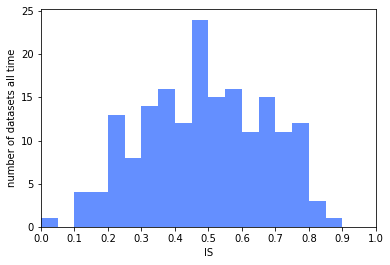

In [35]:
df_features_IS_all_time = df_features_IS.drop('publicationYear',axis=1).drop_duplicates()
ls_influence_score_all_time = []
for dataset in df_features_IS_all_time.index:
    ls_influence_score_all_time.append(influence_score(df_features_IS_all_time.loc[dataset])) #, weights=[0, 1, 0, 0, 0, 0, 0, 0]
ls_influence_score_all_time

plt.hist(ls_influence_score_all_time, bins=20, range=(0,1), color='#648fff')
plt.xlabel('IS')
plt.ylabel('number of datasets all time')
plt.xlim((0,1))
plt.xticks(np.array([*range(0, 11)])/10)
plt.savefig('output/hist_all_at_influence_score.pdf')
plt.show()

Subset with papers from 2022 and add column with influence score


In [36]:
df_features_IS_2022 = df_features_IS.loc[df_features_IS['publicationYear']==2022] #just datasets from 2022
df_features_IS_2022 = df_features_IS_2022.drop('publicationYear', axis=1).drop_duplicates()
ls_influence_score = []
for dataset in df_features_IS_2022.index:
    ls_influence_score.append(influence_score(df_features_IS_2022.loc[dataset]))
ls_influence_score
df_features_IS_2022['InfluenceScore'] = ls_influence_score
df_features_IS_2022 = df_features_IS_2022.sort_values('InfluenceScore', ascending=False)
df_features_IS_2022_to_save = df_features_IS_2022.round(decimals=2)
df_features_IS_2022_to_save.to_csv('output/InfluenceScore2022.csv')
df_features_IS_2022

,cit,h-cit,refs,authors,sensors,frames,Altmetric,readers,InfluenceScore
Waymo Block-NeRF,0.661111,0.500000,0.944444,0.866667,NaN,NaN,0.290984,NaN,0.652641
Street Hazards,0.633333,0.544444,0.822222,0.911111,0.242775,0.149533,NaN,NaN,0.612129
SHIFT,0.183333,0.180556,0.994444,0.872222,0.763006,0.943925,0.290984,NaN,0.577577
ScribbleKITTI,0.183333,0.136111,0.797222,0.966667,0.242775,0.327103,NaN,NaN,0.482087
Rope3D,0.130556,0.136111,0.822222,0.422222,0.572254,0.514019,0.290984,NaN,0.386019
CODA,0.183333,0.136111,0.733333,0.361111,0.242775,NaN,NaN,NaN,0.353472
CARLA-WildLife (CWL),0.033333,0.055556,0.925000,0.119444,0.242775,NaN,NaN,NaN,0.283333
AugKITTI,0.033333,0.055556,0.877778,0.158333,NaN,NaN,NaN,NaN,0.281250
RoadSaW,0.033333,0.055556,0.272222,0.194444,0.242775,0.822430,NaN,NaN,0.275597
Street Obstacle Sequences (SOS),0.033333,0.055556,0.925000,0.119444,0.242775,0.065421,NaN,NaN,0.239751


In [37]:
df_features_IS_2022.max(axis=0)

cit               0.661111
h-cit             0.544444
refs              0.994444
authors           0.966667
sensors           0.921965
frames            0.943925
Altmetric         0.290984
readers                NaN
InfluenceScore    0.652641
dtype: float64

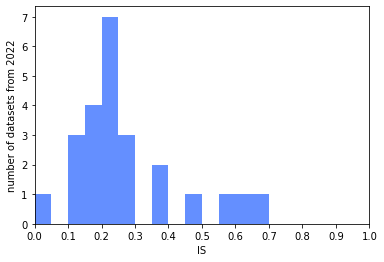

In [38]:
plt.hist(ls_influence_score, bins=20, range=(0,1), color='#648fff')
plt.xlabel('IS')
plt.ylabel('number of datasets from 2022')
plt.xlim((0,1))
plt.xticks(np.array([*range(0, 11)])/10)
plt.savefig('output/hist_2022_influence_score.pdf')
plt.show()

### Top and Bottom 5 by citation count all time - time line

1. arrays with all features (citations, h-index citations, references, authors, sensors, frames)
2. percentile rank by year of each feature
3. Influence Score
4. Plot

#### 1st Create arrays

In [39]:
references_array = np.empty([len(retrieved_data), 15])
citations_array = np.empty([len(retrieved_data), 15])
citations_citations_array = np.empty([len(retrieved_data), 15])
author_array = np.empty([len(retrieved_data), 15])
citations_citations_sum_array = np.empty([len(retrieved_data), 15])
sensors_array = np.empty([len(retrieved_data), 15])
frames_array = np.empty([len(retrieved_data), 15])

references_array[:] = np.nan
citations_array[:] = np.nan
citations_citations_array[:] = np.nan
author_array[:] = np.nan
sensors_array[:] = np.nan
frames_array[:] = np.nan
citations_citations_sum_array[:] = np.nan

names = []
for paper_idx, o_paper in enumerate(tqdm(retrieved_data)):
    names.append(o_paper['id'])
    print(o_paper['id'])
    try:
        sensors_array[paper_idx, o_paper['paperInfo']['year']-2008:] =  int(len(list(o_paper['sensors'].split(','))))
    except:
        sensors_array[paper_idx, o_paper['paperInfo']['year']-2008:] =  float("NaN")
    try:
        if o_paper['frames'] != "-":
                frames_array[paper_idx, o_paper['paperInfo']['year']-2008:] = int(o_paper['frames'].replace(',', ''))
    except:
                frames_array[paper_idx, o_paper['paperInfo']['year']-2008:] = float("NaN")
    for index in range(14, 0, -1): #index = 16 = year 2022
        dist = 2008 + index - o_paper['paperInfo']['year']
        if dist < 0:
            break
        #print(dist)
        #scorer = scoring(o_paper, 3, dist, dist) # three years prior to publication, until dist. example: publication 2018. from 2015 to 2022
        scorer = scoring(o_paper, -dist+2, dist, dist)
        print(scorer.lower_bound, scorer.upper_bound, scorer.just_citations())
        ls_author_scores = []
        for author_number, author in enumerate(o_paper['paperInfo']['authors']):
            single_author_score = scorer.citations_single_author_score(author_number)
            ls_author_scores.append(single_author_score)
        author_array[paper_idx, index] = np.mean(ls_author_scores)
        references_array[paper_idx, index] = scorer.reference_score()
        citations_array[paper_idx, index] = scorer.just_citations()
        citations_citations_array[paper_idx, index] = scorer.citations_citations_score()
        citations_citations_sum_array[paper_idx, index] = scorer.citations_citations_sum()


  0%|          | 0/185 [00:00<?, ?it/s]

KITTI
2020 2022 3004
2019 2021 2885
2018 2020 2486
2017 2019 1819
2016 2018 1195


  1%|          | 1/185 [00:00<01:04,  2.86it/s]

2015 2017 779
2014 2016 496
2013 2015 258
2012 2014 90
2011 2013 7
Cars
2020 2022 1305
2019 2021 1104
2018 2020 836
2017 2019 555
2016 2018 329


  2%|▏         | 4/185 [00:00<00:26,  6.81it/s]

2015 2017 189
2014 2016 85
2013 2015 34
2012 2014 10
2011 2013 1
nuImages
2020 2022 1720
2019 2021 1051
2018 2020 479
2017 2019 97
nuScenes
2020 2022 1720
2019 2021 1051
2018 2020 479
2017 2019 97
Synthia
2020 2022 918
2019 2021 913
2018 2020 803


  3%|▎         | 5/185 [00:00<00:26,  6.76it/s]

2017 2019 592
2016 2018 356
2015 2017 142
2014 2016 31
GTA5
2020 2022 780
2019 2021 753
2018 2020 648
2017 2019 498
2016 2018 304
2015 2017 125
2014 2016 23


  4%|▍         | 7/185 [00:01<00:30,  5.75it/s]

Caltech Pedestrian
2020 2022 333
2019 2021 360
2018 2020 370
2017 2019 356
2016 2018 314
2015 2017 285
2014 2016 250
2013 2015 246
2012 2014 232
2011 2013 247
2010 2012 238
2009 2011 172
2008 2010 77
2007 2009 11
CamVid
2020 2022 468
2019 2021 485


  4%|▍         | 8/185 [00:01<00:32,  5.38it/s]

2018 2020 470
2017 2019 375
2016 2018 271
2015 2017 155
2014 2016 85
2013 2015 58
2012 2014 51
2011 2013 47
2010 2012 42
2009 2011 31
2008 2010 17
2007 2009 6
Oxford Robot Car
2020 2022 619
2019 2021 591
2018 2020 502
2017 2019 322
2016 2018 167
2015 2017 56
Waymo Open Perception
2020 2022 886


  6%|▌         | 11/185 [00:01<00:22,  7.88it/s]

2019 2021 464
2018 2020 162
2017 2019 9
GTSRB
2020 2022 316
2019 2021 342
2018 2020 354
2017 2019 295
2016 2018 214
2015 2017 140
2014 2016 98
2013 2015 77
2012 2014 63
2011 2013 49
2010 2012 34
2009 2011 14
Mapillary Vistas
2020 2022 528
2019 2021 495


  8%|▊         | 14/185 [00:01<00:17, 10.05it/s]

2018 2020 385
2017 2019 229
2016 2018 70
2015 2017 4
Caltech Lanes
2020 2022 201
2019 2021 229
2018 2020 273
2017 2019 257
2016 2018 247
2015 2017 205
2014 2016 170
2013 2015 144
2012 2014 115
2011 2013 88
2010 2012 59
2009 2011 35
2008 2010 17
2007 2009 5
BDD100k
2020 2022 613
2019 2021 378
2018 2020 144
2017 2019 74
2016 2018 13


  9%|▊         | 16/185 [00:02<00:15, 10.62it/s]

Beyond PASCAL
2020 2022 249
2019 2021 295
2018 2020 326
2017 2019 299
2016 2018 245
2015 2017 171
2014 2016 111
2013 2015 58
2012 2014 11
Argoverse 3D Tracking
2020 2022 557
2019 2021 369
2018 2020 183
2017 2019 37
Argoverse Motion Forecasting
2020 2022 557
2019 2021 369
2018 2020 183
2017 2019 37
GTSDB
2020 2022 263


 10%|▉         | 18/185 [00:02<00:14, 11.31it/s]

2019 2021 269
2018 2020 249
2017 2019 224
2016 2018 171
2015 2017 130
2014 2016 90
2013 2015 63
2012 2014 34
2011 2013 12
LISA Traffic Sign
2020 2022 166
2019 2021 213
2018 2020 223
2017 2019 215
2016 2018 174
2015 2017 175
2014 2016 142
2013 2015 116
2012 2014 58
2011 2013 23
2010 2012 5
TT100K
2020 2022 236
2019 2021 244
2018 2020 224


 11%|█         | 20/185 [00:02<00:14, 11.25it/s]

2017 2019 202
2016 2018 117
2015 2017 52
2014 2016 2
CULane
2020 2022 355
2019 2021 276
2018 2020 180
2017 2019 76
2016 2018 19
2015 2017 1
TUD Brussels
2020 2022 57
2019 2021 73
2018 2020 96
2017 2019 113
2016 2018 116
2015 2017 121
2014 2016 114


 12%|█▏        | 22/185 [00:02<00:16,  9.65it/s]

2013 2015 126
2012 2014 106
2011 2013 106
2010 2012 86
2009 2011 63
2008 2010 27
2007 2009 2
ApolloScape
2020 2022 244
2019 2021 181
2018 2020 106
2017 2019 40
2016 2018 10
Road Damage
2020 2022 192
2019 2021 173
2018 2020 108
2017 2019 36
2016 2018 7


 14%|█▍        | 26/185 [00:03<00:14, 10.68it/s]

VPGNet
2020 2022 204
2019 2021 204
2018 2020 160
2017 2019 76
2016 2018 28
2015 2017 0
DDAD
2020 2022 260
2019 2021 150
2018 2020 44
2017 2019 7
NoCrash
2020 2022 202
2019 2021 134
2018 2020 67
2017 2019 18
Malaga Stereo and Laser Urban
2020 2022 89
2019 2021 105
2018 2020 104


 16%|█▌        | 29/185 [00:03<00:11, 13.91it/s]

2017 2019 92
2016 2018 69
2015 2017 52
2014 2016 29
2013 2015 16
2012 2014 3
INTERACTION
2020 2022 192
2019 2021 119
2018 2020 54
2017 2019 6
Brain4Cars
2020 2022 77
2019 2021 96
2018 2020 116
2017 2019 93
2016 2018 78
2015 2017 43
2014 2016 24
2013 2015 4
comma.ai
2020 2022 79
2019 2021 108
2018 2020 115
2017 2019 99
2016 2018 71
2015 2017 33
2014 2016 10


 18%|█▊        | 34/185 [00:03<00:09, 15.74it/s]

Oxford Radar Robot Car
2020 2022 168
2019 2021 110
2018 2020 48
2017 2019 5
Stanford Track Collection
2020 2022 34
2019 2021 45
2018 2020 53
2017 2019 61
2016 2018 59
2015 2017 61
2014 2016 46
2013 2015 43
2012 2014 33
2011 2013 30
2010 2012 16
2009 2011 6
India Driving
2020 2022 151
2019 2021 100
2018 2020 51
2017 2019 18
2016 2018 2
LISA Traffic Light
2020 2022 67
2019 2021 87
2018 2020 91
2017 2019 82
2016 2018 60
2015 2017 33
2014 2016 12
Bosch Small Traffic Lights Dataset
2020 2022 88
2019 2021 106
2018 2020 99
2017 2019 66


 21%|██        | 38/185 [00:03<00:09, 15.85it/s]

2016 2018 24
2015 2017 2
Bosch TL
2020 2022 88
2019 2021 106
2018 2020 99
2017 2019 66
2016 2018 24
2015 2017 2
DR(eye)VE
2020 2022 105
2019 2021 101
2018 2020 74
2017 2019 43
2016 2018 10
2015 2017 4
KITTI-360
2020 2022 77
2019 2021 71
2018 2020 49
2017 2019 57
2016 2018 48


 23%|██▎       | 42/185 [00:04<00:09, 15.04it/s]

2015 2017 29
2014 2016 7
2013 2015 0
JAAD
2020 2022 105
2019 2021 96
2018 2020 71
2017 2019 32
2016 2018 11
2015 2017 0
Nighttime Driving
2020 2022 109
2019 2021 86
2018 2020 54
2017 2019 27
2016 2018 3
TME Motorway
2020 2022 22
2019 2021 28
2018 2020 35
2017 2019 42
2016 2018 50
2015 2017 63
2014 2016 57
2013 2015 47
2012 2014 24
2011 2013 12
2010 2012 2
KAIST Multi-Spectral Day/Night
2020 2022 113
2019 2021 89
2018 2020 53
2017 2019 20
2016 2018 3
Lyft Level5 Perception
2020 2022 124
2019 2021 56
2018 2020 8
Lyft Level5 Prediction
2020 2022 124


 27%|██▋       | 50/185 [00:04<00:05, 23.61it/s]

2019 2021 56
2018 2020 8
One Thousand and One Hours
2020 2022 124
2019 2021 56
2018 2020 8
H3D
2020 2022 106
2019 2021 85
2018 2020 49
2017 2019 17
WoodScape
2020 2022 107
2019 2021 81
2018 2020 36
2017 2019 13
A2D2
2020 2022 116
2019 2021 70
2018 2020 24
Complex Urban
2020 2022 101
2019 2021 78
2018 2020 43
2017 2019 13
Synscapes
2020 2022 91
2019 2021 78
2018 2020 45
2017 2019 16
2016 2018 2
Waymo Open Motion
2020 2022 109
2019 2021 24
WildDash
2020 2022 85
2019 2021 66
2018 2020 40
2017 2019 20
2016 2018 2
UAH-DriveSet
2020 2022 60
2019 2021 68
2018 2020 60
2017 2019 37
2016 2018 11
2015 2017 3


 30%|██▉       | 55/185 [00:04<00:04, 26.36it/s]

2014 2016 0
BoxCars116k
2020 2022 66
2019 2021 72
2018 2020 62
2017 2019 30
2016 2018 9
2015 2017 0
Ground Truth Stixel
2020 2022 11
2019 2021 17
2018 2020 22
2017 2019 40
2016 2018 48
2015 2017 52
2014 2016 41
2013 2015 29
2012 2014 15
2011 2013 4
DBNet
2020 2022 52
2019 2021 60
2018 2020 52
2017 2019 34
2016 2018 9
LiDAR-Video Driving
2020 2022 52
2019 2021 60


 33%|███▎      | 61/185 [00:04<00:05, 23.44it/s]

2018 2020 52
2017 2019 34
2016 2018 9
LostAndFound
2020 2022 61
2019 2021 45
2018 2020 30
2017 2019 22
2016 2018 10
2015 2017 5
2014 2016 1
Waymo Block-NeRF
2020 2022 83
HD1K
2020 2022 59
2019 2021 37
2018 2020 27
2017 2019 19
2016 2018 13
2015 2017 6
2014 2016 1
Tsinghua Daimler Cyclist Detection
2020 2022 33
2019 2021 48
2018 2020 46
2017 2019 43
2016 2018 23
2015 2017 14
2014 2016 3
CADC
2020 2022 74


 36%|███▌      | 67/185 [00:04<00:05, 23.20it/s]

2019 2021 37
2018 2020 11
Street Hazards
2020 2022 70
HCI Challenging Stereo
2020 2022 9
2019 2021 14
2018 2020 16
2017 2019 22
2016 2018 16
2015 2017 25
2014 2016 24
2013 2015 29
2012 2014 22
2011 2013 15
2010 2012 7
Toronto 3D
2020 2022 66
2019 2021 40
2018 2020 7
Fishyscapes
2020 2022 59
2019 2021 36
2018 2020 15
2017 2019 7
A*3D
2020 2022 51
2019 2021 33
2018 2020 15


 38%|███▊      | 70/185 [00:05<00:05, 20.79it/s]

2017 2019 4
NightOwls
2020 2022 44
2019 2021 36
2018 2020 21
2017 2019 7
2016 2018 2
EuroCity Persons
2020 2022 112
2019 2021 106
2018 2020 79
2017 2019 31
SemanticPOSS
2020 2022 49
2019 2021 24
2018 2020 11
ONCE
2020 2022 48
2019 2021 9
RELLIS-3D
2020 2022 48
2019 2021 20
2018 2020 1
rounD
2020 2022 44
2019 2021 19


 43%|████▎     | 80/185 [00:05<00:03, 29.56it/s]

2018 2020 3
PointCloudDeNoising
2020 2022 33
2019 2021 10
2018 2020 2
2017 2019 0
Ford Autonomous Vehicle
2020 2022 41
2019 2021 21
2018 2020 9
CADP
2020 2022 32
2019 2021 26
2018 2020 16
2017 2019 9
2016 2018 0
LIBRE
2020 2022 39
2019 2021 25
2018 2020 6
D^2 City
2020 2022 34
2019 2021 29
2018 2020 15
2017 2019 3
CARRADA
2020 2022 36
2019 2021 17
2018 2020 1
Comma2k19
2020 2022 30
2019 2021 20
2018 2020 12
2017 2019 4
2016 2018 1
RADIATE
2020 2022 27
2019 2021 3
2018 2020 1
Street Learn
2020 2022 24
2019 2021 27
2018 2020 14
2017 2019 8
DIPLECS Autonomous Driving
2020 2022 18


 47%|████▋     | 87/185 [00:05<00:03, 26.54it/s]

2019 2021 17
2018 2020 13
2017 2019 10
2016 2018 9
2015 2017 6
2014 2016 3
2013 2015 0
Talk2Car
2020 2022 29
2019 2021 20
2018 2020 11
2017 2019 2
Raincouver
2020 2022 21
2019 2021 19
2018 2020 13
2017 2019 9
2016 2018 2
2015 2017 0
RoadAnomaly21
2020 2022 29
2019 2021 5
RoadObstacle21
2020 2022 29
2019 2021 5
4Seasons
2020 2022 27
2019 2021 10
2018 2020 0


 51%|█████     | 94/185 [00:05<00:03, 26.91it/s]

BLVD
2020 2022 21
2019 2021 19
2018 2020 13
2017 2019 5
DDD20: DAVIS Driving 2020
2020 2022 26
2019 2021 14
2018 2020 3
MTSD
2020 2022 26
2019 2021 11
2018 2020 3
2017 2019 0
Unsupervised Llamas
2020 2022 25
2019 2021 11
2018 2020 4
2017 2019 0
Bay Area
2020 2022 7
2019 2021 6
2018 2020 10
2017 2019 9
2016 2018 12
2015 2017 9
2014 2016 8
2013 2015 4
2012 2014 1
Illumination Changes in a day
2020 2022 7
2019 2021 6
2018 2020 10
2017 2019 9
2016 2018 12
2015 2017 9
2014 2016 8


 56%|█████▌    | 103/185 [00:06<00:02, 33.74it/s]

2013 2015 4
2012 2014 1
RANUS
2020 2022 17
2019 2021 18
2018 2020 13
2017 2019 8
2016 2018 1
Seasonal Variation
2020 2022 7
2019 2021 6
2018 2020 10
2017 2019 9
2016 2018 12
2015 2017 9
2014 2016 8
2013 2015 4
2012 2014 1
Cityscapes 3D
2020 2022 23
2019 2021 8
2018 2020 1
DriveU Traffic Light
2020 2022 13
2019 2021 15
2018 2020 13
2017 2019 10
2016 2018 3
PREVENTION
2020 2022 23
2019 2021 14
2018 2020 7
2017 2019 0
RadarScenes
2020 2022 23
2019 2021 11
CCSAD
2020 2022 9
2019 2021 6
2018 2020 11
2017 2019 11
2016 2018 9
2015 2017 4
2014 2016 2
2013 2015 0
KITTI-360 PanopticBEV
2020 2022 20
2019 2021 2
nuPlan
2020 2022 21
2019 2021 3
nuScenes PanopticBEV
2020 2022 20
2019 2021 2
AMUSE
2020 2022 6
2019 2021 9


 58%|█████▊    | 107/185 [00:06<00:02, 32.80it/s]

2018 2020 8
2017 2019 9
2016 2018 4
2015 2017 5
2014 2016 3
2013 2015 3
2012 2014 1
2011 2013 0
Boxy
2020 2022 16
2019 2021 11
2018 2020 8
2017 2019 1
ROAD
2020 2022 16
2019 2021 2
openDD
2020 2022 14
2019 2021 8
2018 2020 1
MCity Data Collection
2020 2022 11
2019 2021 8
2018 2020 4
2017 2019 0
Semantic KITTI
2020 2022 620
2019 2021 369
2018 2020 154


 62%|██████▏   | 115/185 [00:06<00:02, 33.68it/s]

2017 2019 19
SemanticUSL
2020 2022 12
2019 2021 3
TRoM
2020 2022 6
2019 2021 7
2018 2020 5
2017 2019 3
2016 2018 0
2015 2017 0
Cooperative Driving (CODD)
2020 2022 7
2019 2021 0
PepScenes
2020 2022 6
2019 2021 5
2018 2020 2
ScribbleKITTI
2020 2022 6
SHIFT
2020 2022 6
K-Lane
2020 2022 4
2019 2021 0
WZ-traffic
2020 2022 4
2019 2021 4
2018 2020 2


 68%|██████▊   | 126/185 [00:06<00:01, 42.28it/s]

2017 2019 0
CrashD
2020 2022 3
2019 2021 0
WildDash 2
2020 2022 4
Provident Vehicle Detection at Night (PVDN)
2020 2022 2
2019 2021 1
Amodal Cityscapes
2020 2022 1
DRIV100
2020 2022 1
2019 2021 0
LUMPI
2020 2022 1
MIT-AVT Clustered Driving Scene
2020 2022 1
2019 2021 1
2018 2020 0
A9
2020 2022 8
aiMotive
2020 2022 0
Argoverse 1 Stereo
2020 2022 559
2019 2021 369
2018 2020 183
2017 2019 37
AugKITTI
2020 2022 0
Automatum (Open Highway)
2020 2022 3
2019 2021 0
Autonomous Platform Inertial
2020 2022 6
Boreas
2020 2022 9
CarlaScenes
2020 2022 0


 73%|███████▎  | 135/185 [00:06<00:00, 53.29it/s]

CARLA-WildLife (CWL)
2020 2022 0
Cityscapes-DVPS
2020 2022 58
2019 2021 29
2018 2020 2
CODA
2020 2022 6
CURE-TSD
2020 2022 31
2019 2021 19
2018 2020 12
2017 2019 1
CURE-TSR
2020 2022 28
2019 2021 28
2018 2020 29
2017 2019 17
2016 2018 8
2015 2017 0
DGL-MOTS
2020 2022 333
2019 2021 248
2018 2020 126
2017 2019 23
ETH Pedestrian
2020 2022 142
2019 2021 138


 76%|███████▌  | 141/185 [00:07<00:01, 32.16it/s]

2018 2020 172
2017 2019 183
2016 2018 201
2015 2017 181
2014 2016 173
2013 2015 144
2012 2014 128
2011 2013 105
2010 2012 104
2009 2011 97
2008 2010 68
2007 2009 34
exiD
2020 2022 2
Five Roundabouts
2020 2022 87
2019 2021 70
2018 2020 44
2017 2019 19
2016 2018 5
Ford CAMPUS
2020 2022 110
2019 2021 112
2018 2020 106
2017 2019 95
2016 2018 77
2015 2017 65
2014 2016 53
2013 2015 54
2012 2014 52
2011 2013 36
2010 2012 20
2009 2011 6
Gated2Depth
2020 2022 22


 81%|████████  | 150/185 [00:07<00:01, 33.23it/s]

2019 2021 20
2018 2020 10
2017 2019 4
Gated2Gated
2020 2022 1
2019 2021 1
GROUNDED
2020 2022 2
2019 2021 1
HAD
2020 2022 25
2019 2021 22
2018 2020 14
2017 2019 4
HDBD
2020 2022 0
HDD
2020 2022 109
2019 2021 111
2018 2020 83
2017 2019 48
2016 2018 7
HEV-I
2020 2022 61
2019 2021 59
2018 2020 41
2017 2019 13
2016 2018 0
highD
2020 2022 361


 88%|████████▊ | 162/185 [00:07<00:00, 42.57it/s]

2019 2021 265
2018 2020 154
2017 2019 42
2016 2018 4
HSD
2020 2022 11
2019 2021 9
2018 2020 6
2017 2019 2
IDDA
2020 2022 20
2019 2021 5
2018 2020 0
inD
2020 2022 131
2019 2021 64
2018 2020 25
2017 2019 0
IPS300+
2020 2022 3
2019 2021 0
I see you
2020 2022 0
K-Radar
2020 2022 1
LISA Amazon-MLSL Vehicle Attributes (LAVA)
2020 2022 0
2019 2021 0
LOKI
2020 2022 12
2019 2021 3
MAVD Multimodal Audio-Visual Detection
2020 2022 32
2019 2021 7
MOTSynth
2020 2022 30
2019 2021 2
MuIRan
2020 2022 90
2019 2021 45
2018 2020 17
Multi Vehicle Stereo Event Camera
2020 2022 164
2019 2021 137
2018 2020 85
2017 2019 46
2016 2018 13
NCLT
2020 2022 158
2019 2021 144
2018 2020 118
2017 2019 90
2016 2018 58
2015 2017 25
2014 2016 10
OpenMPD
2020 2022 5
PIE
2020 2022 96
2019 2021 70
2018 2020 28
2017 2019 0
R3 Driving
2020 2022 0
2019 2021 0
RoadSaW
2020 2022 0


 91%|█████████▏| 169/185 [00:07<00:00, 48.53it/s]

Rope3D
2020 2022 3
RUGD: Robot Unstructured Ground Driving
2020 2022 47
2019 2021 24
2018 2020 2
2017 2019 0
R-U-MAAD
2020 2022 0
SeeingThroughFog
2020 2022 103
2019 2021 46
2018 2020 7
2017 2019 2
SemKITTI-DVPS
2020 2022 58
2019 2021 29
2018 2020 2


 95%|█████████▍| 175/185 [00:08<00:00, 38.46it/s]

Small Obstacle
2020 2022 8
2019 2021 3
2018 2020 1
SODA10M
2020 2022 7
2019 2021 0
Stanford Drone
2020 2022 333
2019 2021 340
2018 2020 293
2017 2019 185
2016 2018 81
2015 2017 29
2014 2016 1
Street Obstacle Sequences (SOS)
2020 2022 0
Synthetic Discrepancy
2020 2022 61
2019 2021 31
2018 2020 12
2017 2019 5
TAF-BW
2020 2022 11
2019 2021 14
2018 2020 9
2017 2019 5


100%|██████████| 185/185 [00:08<00:00, 22.09it/s]

2016 2018 0
TITAN
2020 2022 52
2019 2021 33
2018 2020 20
USyd Campus
2020 2022 8
2019 2021 5
2018 2020 1
UTBM EU LTD
2020 2022 32
2019 2021 22
2018 2020 9
2017 2019 3
VLMV - Vehicle Lane Merge Visual Benchmark
2020 2022 1
2019 2021 0
Wuppertal Obstacle Sequences (WOS)
2020 2022 0


In [40]:
#make list of tupels with (feature_name, array)
arrays_over_time = [('percentile $ref_{h3}$', references_array), ('percentile $n_{cit3}$', citations_array), ('percentile $cit_{h3}$', citations_citations_array), ('percentile $aut_{\mu h3}$', author_array), ('percentile $n_{sensors}$', sensors_array), ('percentile $n_{frames}$', frames_array)]

In [41]:
def percentile_rank(np_array):
    """takes np_array and calculates percentile ranks by column (year)"""
    df_percentile_ranks = pd.DataFrame(np_array)
    return np.array(df_percentile_ranks.rank(pct=True, axis=0))

#### 2nd calculate all percentile ranks

In [42]:
nan_array = np.empty([len(retrieved_data), 15])
nan_array[:] = np.nan
percentile_array = [('IS', nan_array)]
for array in arrays_over_time:
    percentile_array.append((array[0], percentile_rank(array[1])))
print('Feature:', percentile_array[2][0])
percentile_array[2][1]

Feature: percentile $n_{cit3}$


array([[       nan,        nan,        nan, ..., 1.        , 1.        ,
        1.        ],
       [       nan,        nan,        nan, ..., 0.99253731, 0.99375   ,
        0.98378378],
       [       nan,        nan,        nan, ..., 0.95895522, 0.984375  ,
        0.99189189],
       ...,
       [       nan,        nan,        nan, ..., 0.25373134, 0.415625  ,
        0.47027027],
       [       nan,        nan,        nan, ...,        nan, 0.034375  ,
        0.08648649],
       [       nan,        nan,        nan, ...,        nan,        nan,
        0.03513514]])

#### 3rd Iterate over created feature-arrays and calculate influence score

In [43]:
# selected_features = ['Altmetric', 'cit', 'h-cit', 'readers', 'refs', 'authors', 'frames']
#
for dataset in range(percentile_array[1][1].shape[0]):
    print(dataset, percentile_array[1][1].shape[0])
    for year in range(percentile_array[1][1].shape[1]):
        if not np.isnan(percentile_array[3][1][dataset][year]):
            scores = pd.Series({percentile_array[1][0]: percentile_array[1][1][dataset][year], percentile_array[2][0]: percentile_array[2][1][dataset][year], percentile_array[3][0]: percentile_array[3][1][dataset][year], percentile_array[4][0]: percentile_array[4][1][dataset][year], percentile_array[5][0]: percentile_array[5][1][dataset][year], percentile_array[6][0]: percentile_array[6][1][dataset][year]})
            print(scores)
            percentile_array[0][1][dataset][year] = influence_score(scores, selected_features='all')
#

0 185
percentile $ref_{h3}$        0.25000
percentile $n_{cit3}$        0.25000
percentile $cit_{h3}$        0.25000
percentile $aut_{\mu h3}$    0.06250
percentile $n_{sensors}$     0.90625
percentile $n_{frames}$          NaN
dtype: float64
percentile $ref_{h3}$        0.190476
percentile $n_{cit3}$        0.809524
percentile $cit_{h3}$        0.452381
percentile $aut_{\mu h3}$    0.047619
percentile $n_{sensors}$     0.904762
percentile $n_{frames}$           NaN
dtype: float64
percentile $ref_{h3}$        0.20
percentile $n_{cit3}$        1.00
percentile $cit_{h3}$        0.78
percentile $aut_{\mu h3}$    0.04
percentile $n_{sensors}$     0.86
percentile $n_{frames}$       NaN
dtype: float64
percentile $ref_{h3}$        0.125000
percentile $n_{cit3}$        1.000000
percentile $cit_{h3}$        0.916667
percentile $aut_{\mu h3}$    0.027778
percentile $n_{sensors}$     0.875000
percentile $n_{frames}$           NaN
dtype: float64
percentile $ref_{h3}$        0.125000
percentile $n_

Select top and bottom 5

In [44]:
top_5 = pd.DataFrame(percentile_array[2][1]).dropna(thresh=4).drop_duplicates().sort_values(14, axis=0, ascending=False).iloc[:5, :]
# drop_duplicates removes nuScenes because it is a duplicate of nuImages (although frames differ slightly. Leeds to very confusing plots)
top_5

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,NaN,NaN,NaN,NaN,NaN,0.250,0.809524,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.828704,0.958955,0.984375,0.991892
1,NaN,NaN,NaN,NaN,NaN,0.125,0.285714,0.48,0.736111,0.937500,0.971014,0.981481,0.992537,0.993750,0.983784
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.583333,0.833333,0.985507,0.990741,0.985075,0.975000,0.978378
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.324074,0.835821,0.943750,0.972973


In [45]:
bottom_5 = pd.DataFrame(percentile_array[2][1]).dropna(thresh=4).sort_values(14, axis=0, ascending=True).iloc[:5, :]
bottom_5

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.046296,0.100746,0.150000,0.151351
112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.072917,0.036232,0.148148,0.164179,0.215625,0.183784
105,NaN,NaN,NaN,NaN,NaN,0.0625,0.119048,0.16,0.222222,0.302083,0.224638,0.324074,0.223881,0.250000,0.183784
94,NaN,NaN,NaN,NaN,NaN,NaN,0.119048,0.26,0.333333,0.395833,0.463768,0.324074,0.279851,0.196875,0.216216
96,NaN,NaN,NaN,NaN,NaN,NaN,0.119048,0.26,0.333333,0.395833,0.463768,0.324074,0.279851,0.196875,0.216216


In [46]:
top_and_bottom_5 = list(top_5.index) + list(bottom_5.index)[::-1]
top_bottom_names = []
for ids in top_and_bottom_5:
    top_bottom_names.append(names[ids])
print(top_and_bottom_5)
top_bottom_names

[0, 2, 1, 4, 9, 96, 94, 105, 112, 118]


['KITTI',
 'nuImages',
 'Cars',
 'Synthia',
 'Waymo Open Perception',
 'Seasonal Variation',
 'Illumination Changes in a day',
 'AMUSE',
 'TRoM',
 'WZ-traffic']

#### 4th Plot

10 10


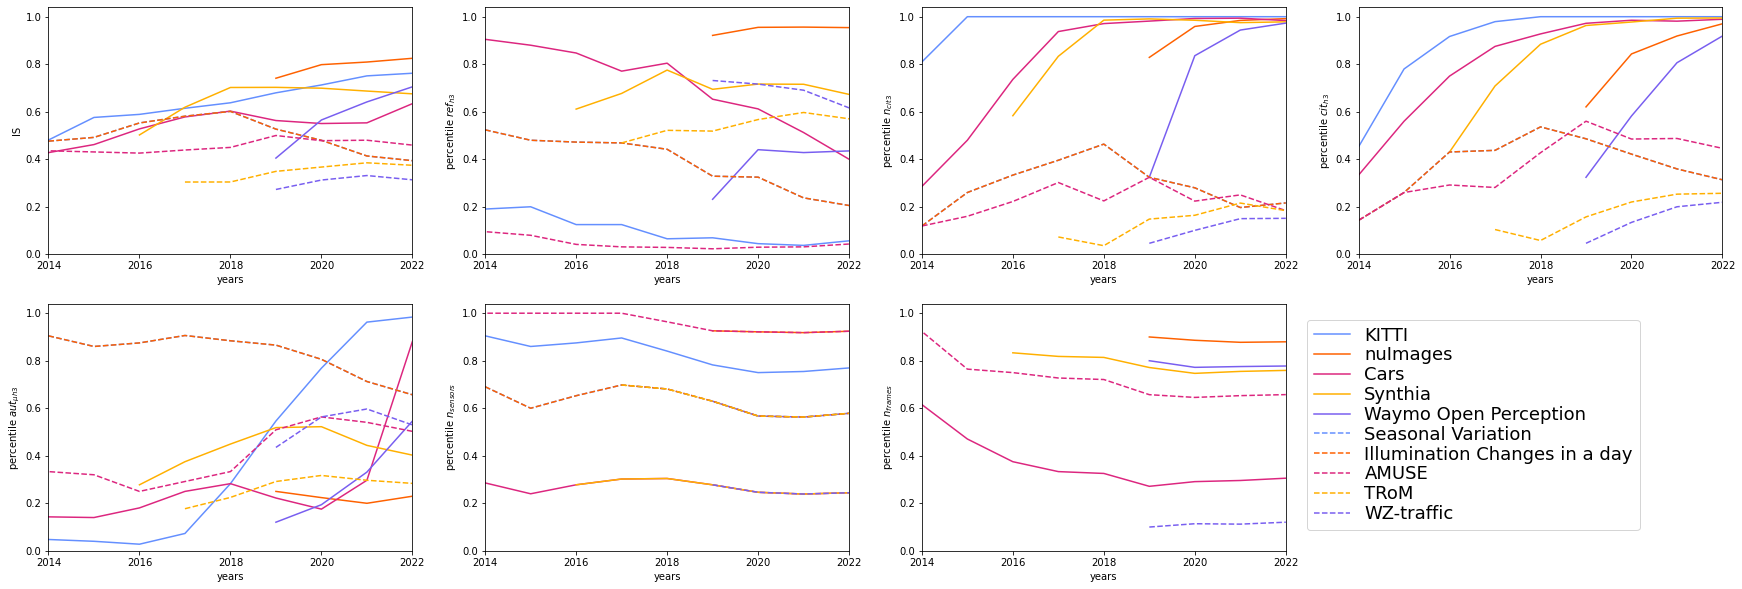

In [47]:
colors = ['#648fff', '#fe6100', '#dc267f', '#ffb000', '#785ef0', '#648fff', '#fe6100', '#dc267f', '#ffb000', '#785ef0']
print(len(colors), len(top_and_bottom_5))
fig, axs = plt.subplots(figsize=(30, 10), nrows=2, ncols=4) #20 8
#fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)
first = True
c = 0
plt.rcParams.update({'font.size': 18})
percentile_array.append('placeholder')
for ax, feature in zip(axs.flat, percentile_array):
    c += 1
    if c == 8:
        #ax.plot()
        #ax.legend(top_bottom_names, loc='best', labelspacing=0.1, fontsize='medium')
        ax.set_axis_off()
        continue
    for i_row, row in enumerate(top_and_bottom_5):
        if i_row >= 5:
            style='dashed'
        else:
            style='solid'
        ax.plot([*range(2008, 2023)], feature[1][row], label=names[row], color=colors[i_row], linestyle=style)
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=feature[0])
    if first:
        #ax.legend(top_bottom_names, loc='lower center', labelspacing=0.1, fontsize='medium')
        first = False
fig.legend(top_bottom_names, loc=[0.75, 0.1], labelspacing=0.1, fontsize='medium')
plt.savefig('output/influence_scores_pr.pdf', bbox_inches='tight')
plt.show()
plt.rcParams.update({'font.size': 10})

In [48]:
ooo

NameError: name 'ooo' is not defined

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

N = 6
theta = radar_factory(N, frame='polygon')
values = [[], [], [], []]
web_names = [[], [], [], []]
data = []
k = 0
for i in range(12):
    row = (spider_web.iloc[i][-6:])
    if i%3 == 0 and i != 0:
        k += 1
    print(k)
    values[k].append( list(row))
    web_names[k].append(row.name)

dimension_names = []
for name in enumerate(list(spider_web.columns[-6:])):
    #print(name[1])
    dimension_names.append(name[1].replace('author', '   author'))
data = [dimension_names, ('', web_names[0], values[0]), ('', web_names[1], values[1]), ('', web_names[2], values[2]), ('', web_names[3], values[3])]

#print(data)
spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(16, 4), nrows=1, ncols=4,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.8, hspace=0.0, top=0.95, bottom=0.05)

# Plot the four cases from the example data on separate axes
colors = ['#648fff', '#dc267f', '#ffb000'] #['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000']
for ax, (title, label, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)
    ax.legend(label, loc=(0.75, -0.15),
                          labelspacing=0.1, fontsize='small')

# add legend relative to top-left plot
#labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
#legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                          labelspacing=0.1, fontsize='small')

#fig.text(0.5, 0.7, 'Influence of Successful Papers',
#         horizontalalignment='center', color='black', weight='bold',
#         size='large')
plt.savefig('output/spider_web_at.pdf', bbox_inches='tight')
plt.show()

In [ ]:
import math
N = 6
theta = radar_factory(N, frame='polygon')
'''values = [[], [], [], []]
web_names = [[], [], [], []]
for i in range(2):
    row = (spider_web.iloc[i][-6:])
    values[0].append(list(row))
    web_names[0].append(row.name)'''

values_21 = [[], []]
web_names_21 = [[], []]
for index, i in enumerate(['Waymo Open Motion', 'SemKITTI-DVPS', 'Cityscapes-DVPS', 'ONCE', 'MAVD Multimodal Audio-Visual Detection', 'MOTSynth', 'RoadAnomaly21']):
    # top 6 ['Waymo Open Motion', 'SemKITTI-DVPS', 'Cityscapes-DVPS', 'ONCE', 'RoadAnomaly21', 'MOTSynth', 'RoadAnomaly21'] #'SemKITTI-DVPS', 'Cityscapes-DVPS' are the same
    if i == 'SemKITTI-DVPS':
        continue
    row = (spider_web.loc[i][-6:])
    if index <= 3:
        values_21[0].append(list(row))
        web_names_21[0].append(row.name)
    else:
        values_21[1].append(list(row))
        web_names_21[1].append(row.name)
dimension_names = []

for name in enumerate(list(spider_web.columns[-6:])):
    #print(name[1])
    dimension_names.append(name[1].replace('_', '\n'))
data = [dimension_names, ('', web_names_21[0], values_21[0]), ('', web_names_21[1], values_21[1])]

print(data)
spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(10, 4), nrows=1, ncols=2,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.2, hspace=0.10, top=0.9, bottom=0.1)

# Plot the four cases from the example data on separate axes
colors = ['#648fff', '#dc267f', '#ffb000'] #['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000']
for ax, (title, label, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    '''ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.4),
                 horizontalalignment='center', verticalalignment='center')'''
    a = 0
    for d, color in zip(case_data, colors):
        for index, score in enumerate(d):
            if math.isnan(score):
                d[index] = 0
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        a += 1
    ax.set_varlabels(spoke_labels)
    ax.legend(label, loc=(0.7, -0.1),
                          labelspacing=0.1, fontsize='small')

# add legend relative to top-left plot
#labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
#legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                          labelspacing=0.1, fontsize='small')

plt.savefig('output/spider_web_at_best_of_21.pdf', bbox_inches='tight')
plt.show()

In [ ]:
same_start_year = False
if same_start_year:
    references_array = np.empty([len(retrieved_data), 15])
    citations_array = np.empty([len(retrieved_data), 15])
    citations_citations_array = np.empty([len(retrieved_data), 15])
    author_array = np.empty([len(retrieved_data), 15])

    references_array[:] = np.nan
    citations_array[:] = np.nan
    citations_citations_array[:] = np.nan
    author_array[:] = np.nan
    names = []
    for paper_idx, o_paper in enumerate(tqdm(retrieved_data)):
        names.append(o_paper['id'])
        for index in range(16):
            yr = o_paper['paperInfo']['year'] + index
            if yr > 2022:
                break
            scorer = scoring(o_paper, 50, index, index)

            ls_author_scores = []
            for author_number, author in enumerate(o_paper['paperInfo']['authors']):
                single_author_score = scorer.citations_single_author_score(author_number)
                ls_author_scores.append(single_author_score)
            author_array[paper_idx, index] = np.mean(ls_author_scores)
            references_array[paper_idx, index] = scorer.reference_score()
            citations_array[paper_idx, index] = scorer.just_citations()
            citations_citations_array[paper_idx, index] = scorer.citations_citations_score()

In [ ]:
if not same_start_year:
    references_array = np.empty([len(retrieved_data), 15])
    citations_array = np.empty([len(retrieved_data), 15])
    citations_citations_array = np.empty([len(retrieved_data), 15])
    author_array = np.empty([len(retrieved_data), 15])
    citations_citations_sum_array = np.empty([len(retrieved_data), 15])
    references_array[:] = np.nan
    citations_array[:] = np.nan
    citations_citations_array[:] = np.nan
    author_array[:] = np.nan
    citations_citations_sum_array[:] = np.nan
    names = []
    for paper_idx, o_paper in enumerate(tqdm(retrieved_data)):
        names.append(o_paper['id'])
        for index in range(14, 0, -1): #index = 16 = year 2022
            dist = 2008+ index-o_paper['paperInfo']['year']
            if dist < 0:
                break
            scorer = scoring(o_paper, 50, dist, dist)

            ls_author_scores = []
            for author_number, author in enumerate(o_paper['paperInfo']['authors']):
                single_author_score = scorer.citations_single_author_score(author_number)
                ls_author_scores.append(single_author_score)
            author_array[paper_idx, index] = np.mean(ls_author_scores)
            references_array[paper_idx, index] = scorer.reference_score()
            citations_array[paper_idx, index] = scorer.just_citations()
            citations_citations_array[paper_idx, index] = scorer.citations_citations_score()
            citations_citations_sum_array[paper_idx, index] = scorer.citations_citations_sum()


In [ ]:
author_df = pd.DataFrame(author_array).set_axis(names)
references_df = pd.DataFrame(references_array).set_axis(names)
citations_df = pd.DataFrame(citations_array).set_axis(names)
citations_citations_df = pd.DataFrame(citations_citations_array).set_axis(names)
citations_citations_sum_df = pd.DataFrame(citations_citations_sum_array).set_axis(names)
for i in range(15):
    author_df.iloc[:, i] = author_df.iloc[:, i].rank(pct = True)
    references_df.iloc[:, i] = references_df.iloc[:, i].rank(pct = True)
    citations_df.iloc[:, i] = citations_df.iloc[:, i].rank(pct = True)
    citations_citations_df.iloc[:, i] = citations_citations_df.iloc[:, i].rank(pct = True)
author_df

In [ ]:
percentile_scores = {"authors": author_df, "references": references_df, "citations": citations_df, "citations_citations": citations_citations_df}

In [ ]:
def relevance_score(scores, alpha=0.25, beta=0.25, gamma=0.25, theta=0.25, relative_c2=False):
    result = scores['references']*alpha + scores['authors']*beta + scores['citations']*gamma + scores['citations_citations']*theta
    if relative_c2:
        result = scores['citations_citations']/scores['citations']
    return result

In [ ]:
relevance_scores = relevance_score(percentile_scores).round(3)
relevance_scores.columns = [*range(2008, 2023)]


In [ ]:
relevance_scores = relevance_scores[pd.notna(relevance_scores[2019])]
relevance_scores = relevance_scores.sort_values([2022], ascending=[False])
relevance_scores.to_csv('output/infSco_equal_weigths.csv', header=[*range(2008, 2023)])

In [ ]:
relevance_scores.duplicated(subset=[2022])

In [ ]:
relevance_scores = relevance_score(percentile_scores, alpha=0, beta=0, gamma=0.5, theta=0.5)

In [ ]:
colors=['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000', '#A740AE']
datasets = ['KITTI','nuImages', 'Synthia', 'Waymo Open Motion', 'Cityscapes-DVPS', 'ONCE']
interest = relevance_scores.loc[datasets]

In [ ]:
ws = [('citations', [0, 0, 1, 0]), ('equal weights', [0.25, 0.25, 0.25, 0.25]), ('citations of citations', [0, 0, 0, 1]),  ('references, authors, citations', [0.33, 0.33, 0.33, 0])]
'''w = ws[0]
relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
for i_row, row in enumerate(datasets):
    plt.plot(relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
plt.legend(loc='best')
plt.show()'''
fig, axs = plt.subplots(figsize=(14, 8), nrows=2, ncols=2)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)

first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(datasets):
        ax.plot([*range(2008, 2023)], relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='medium')
        first = False
plt.savefig('output/influence_scores.pdf')
plt.show()

In [ ]:
ws = [('citations', [0, 0, 1, 0]), ('equal weights', [0.25, 0.25, 0.25, 0.25]), ('citations of citations', [0, 0, 0, 1]),  ('references, authors, citations', [0.33, 0.33, 0.33, 0])]
'''w = ws[0]
relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
for i_row, row in enumerate(datasets):
    plt.plot(relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
plt.legend(loc='best')
plt.show()'''
fig, axs = plt.subplots(figsize=(14, 8), nrows=2, ncols=2)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)

first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(list(relevance_scores.index.values)):
        #print(relevance_scores.loc[row])
        ax.plot([*range(2008, 2023)], relevance_scores.iloc[i_row], label=relevance_scores.iloc[i_row])
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='medium')
        first = False
plt.savefig('output/influence_scores_3.pdf')
plt.show()

In [ ]:

ws = [('citations', [0, 0, 1, 0]), ('equal weights', [0.25, 0.25, 0.25, 0.25]), ('citations of citations', [0, 0, 0, 1]),  ('references, authors, citations', [0.33, 0.33, 0.33, 0])]
'''w = ws[0]
relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
for i_row, row in enumerate(datasets):
    plt.plot(relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
plt.legend(loc='best')
plt.show()'''
fig, axs = plt.subplots(figsize=(14, 8), nrows=2, ncols=2)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)

first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(list(relevance_scores.index.values)):
        #print(relevance_scores.iloc[i_row])
        for i, score in enumerate(relevance_scores.iloc[i_row]):
            if score is not None:
                ax.scatter((2008+i), score, label=relevance_scores.iloc[i_row], alpha=0.3)
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='medium')
        first = False
plt.savefig('output/influence_scores_3.pdf')
plt.show()

In [ ]:
ws = [('equal weights', [0.25, 0.25, 0.25, 0.25])]
ax = plt.subplot()
#ax.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)

first = True
for (scenario_name, w) in ws:
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(list(relevance_scores.index.values)):
        #print(relevance_scores.iloc[i_row])
        for i, score in enumerate(relevance_scores.iloc[i_row]):
            if score is not None:
                ax.scatter((2008+i), score, label=relevance_scores.iloc[i_row], alpha=0.3)
    ax.set(xlim=(2008, 2023), ylim=(0, 1.04), xticks=[*range(2008, 2024, 2)], xlabel='years', ylabel=scenario_name)
    #if first:
    #    ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='medium')
    #    first = False
plt.savefig('output/influence_scores_3.pdf')
plt.show()

In [ ]:
ws = [('citations', [0, 0, 1, 0]), ('h-index of citations', [0, 0, 0, 1]), ('references', [1, 0, 0, 0]), ('authors', [0, 1, 0, 0]), ('equal weights', [0.25, 0.25, 0.25, 0.25]), ('early post release', [0.5, 0, 0.5, 0])]
fig, axs = plt.subplots(figsize=(20, 8), nrows=2, ncols=3)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.8, bottom=0.2)

first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(datasets):
        ax.plot([*range(2008, 2023)], relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
    ax.set(xlim=(2012, 2022), ylim=(0, 1.04), xticks=[*range(2012, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='small')
        first = False
plt.savefig('output/influence_scores2.pdf', bbox_inches='tight')
plt.show()

In [ ]:
colors=['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000', '#E7581E']
ws = [('citations', [0, 0, 1, 0]), ('citations of citations', [0, 0, 0, 1])]
fig, axs = plt.subplots(figsize=(18, 4), nrows=1, ncols=3)
fig.subplots_adjust(wspace=0.2, hspace=0, top=0.8, bottom=0.2)
datasets = ['KITTI', 'Cars Dataset', 'CamVid', 'DIPLECS Autonomous Driving Datasets', 'Illumination Changes in a day', 'AMUSE']
first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3], relative_c2=False)
    for i_row, row in enumerate(datasets):
        ax.plot([*range(2008, 2023)], relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='best', labelspacing=0.1, fontsize='small')
        first = False
#plt.savefig('output/influence_scores2.pdf')
plt.show()

In [ ]:
colors=['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000', '#A740AE']
datasets = ['KITTI','Synthia', 'nuScenes', 'Waymo Open Motion', 'Cityscapes-DVPS', 'ONCE']
interest = relevance_scores.loc[datasets]

In [ ]:
author_df = pd.DataFrame(author_array).set_axis(names)
references_df = pd.DataFrame(references_array).set_axis(names)
citations_df = pd.DataFrame(citations_array).set_axis(names)
citations_citations_df = pd.DataFrame(citations_citations_array).set_axis(names)
citations_citations_sum_df = pd.DataFrame(citations_citations_sum_array).set_axis(names)

In [ ]:
df = citations_citations_sum_df.iloc[:144]
df['citations_citations_rank'] = citations_citations_sum_df.iloc[:144][14]#/citations_df.iloc[:144][14]).rank(pct = True)
df['citation_rank'] = citations_df.iloc[:144][14] #.rank(pct = True)
plt.scatter(df.citation_rank, df.citations_citations_rank, color='#648fff')
plt.xlabel('(citations)')
plt.xlim(0, 1000)
plt.ylabel('(citations of citations)')
plt.savefig('output/citations_of_citations_per_citation.pdf')
plt.show()

In [ ]:
from scipy.stats import pearsonr
pearsonr(df.citation_rank, df.citations_citations_rank)
#correlation coeff, p-value

In [ ]:
x = pd.DataFrame(df.citation_rank)
mod = sm.OLS(df.citations_citations_rank, x.assign(intercept=1))
res = mod.fit()
print(res.summary())

In [ ]:
score  = (df.citations_citations_rank - res.fittedvalues).rank(pct=True)

In [ ]:
plt.scatter(df.citation_rank, list(score), alpha=1, s=4)
plt.xlim(0, 100)
plt.show()

In [ ]:
res.params

In [ ]:
score

In [ ]:
df = citations_citations_df.iloc[:144]
df['citations_citations_rank'] = citations_citations_df.iloc[:144][14].rank(pct = True)
df['citation_rank'] = citations_df.iloc[:144][14].rank(pct = True)
plt.scatter(df.citation_rank, df.citations_citations_rank, color='#648fff')
plt.xlabel('rank(citations)')
plt.ylabel('rank(citations of citations h)')
plt.savefig('output/citations_of_citations_per_citation.pdf')
plt.show()

In [ ]:
from scipy.stats import pearsonr
pearsonr(df.citation_rank, df.citations_citations_rank)
#correlation coeff, p-value